# Random Forest Models 
This notebook implements the empirical analysis using random forest models. Four models are implemented namely the rebel visibility, the rebel strength, the state capacity and the baseline model. Results are interpreted with ALE and PD/ICE plots. The prediction accuracy is validated in cross-validation. The predictions are investigated with appropriate scores namely, AUROC, ROC curves, brier scores, AUPR, and PR curves. The generated dataset is used for the analysis
 

In [1]:
### Load libraries -------
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import os
import yaml

# Random forest and cross validation
from sklearn.ensemble import RandomForestClassifier
from alibi.explainers.ale import ALE, plot_ale
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import brier_score_loss
import sklearn.metrics as metrics
from sklearn.inspection import plot_partial_dependence
from matplotlib.lines import Line2D
from alepython import ale_plot
from pdpbox import pdp

# Pandas parameters
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_rows', 2000)
#pd.set_option('display.max_columns', 500)

In [2]:
### Define plot parameters ------
plt.rcParams["font.family"] = "garamond"
plt.rcParams.update({'font.size': 22})
rcParams.update({'figure.autolayout': True})

In [3]:
### Define out paths ------

# check if out path exists, if it does not exists add the path
if not os.path.exists('C:\\Users\\frank\\Desktop\\master_thesis_out'):
    os.makedirs('C:\\Users\\frank\\Desktop\\master_thesis_out')

# add subfolders for the out path
out_paths = {
    "desciptive_plots_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_plots_outcome',
    "desciptive_tables_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_tables_outcome',
    "data": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data',
    "imp": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data\imp',
    "out": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out',
    "pdplots": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\pdplots',
    "plot_ALE": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\plot_ALE',
    "importance": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\importance',
    "evaluation": 'C:\\Users\\frank\\Desktop\\master_thesis_out\out\evaluation',
}

for path in out_paths.values():
    if not os.path.exists(path):
        os.makedirs(path)
        
out_paths["imp"]

'C:\\Users\\frank\\Desktop\\master_thesis_out\\data\\imp'

In [4]:
### Make a dictionary with fancy names of variables to import into functions  -----
dict_feat_names = {
  "foundloc_cat_cat": "Location of Rebel Group Foundation to Capital",
  "terrain": "Terrain Ruggedness",
  "forest_cov": "Forest Coverage ",
  "rural": "Rural Population ",
  "oil": "Oil Rents",
  "oil_log": "Oil Rents (log)",
  "ident_ethnicity": "Ethnicity  (Identity)",
  "parent_splinter_nonstate": "Splinter Non-State (Pre-existing Organization)",
  "parent_splinter_state": "Splinter State (Pre-existing Organization)",
  "parent_civil_society": "Civil Society (Pre-existing Organization)",
  "parent_merger": "Merger (Pre-existing Organization)",
  "civil_war_dummy": "Transition to Civil War", 
  "active_year_lag": "Transition to Civil Conflict (lag)",
  "gov_qual": "Quality of Government",
  "milexp_in": "Military Expenditure Index",
  "milper_in": "Military Personnel Index",
  "polity2": "Combined Polity Score", 
  'internet_use': "Internet Usage",
  'internet_use_log': "Internet Usage (log)",
  "age_formation": "Age of Rebel Group Since Foundation",
  "ideo_total": "Count of Ideologies",
  "goal_total": "Count of Goals",
}

In [5]:
### Load data -----
df = pd.read_csv(os.path.join(out_paths["data"], "df_imp_1_onset.csv")) ### <----- change to use other imputed datasets
#df = pd.read_csv(os.path.join(out_paths["data"], "df_imp_simple_interpolated_onset.csv"))
print(len(df))
df.head(3)

2065


year StateAbb  ccode cname              side_a  side_a_new_id side_b  \
0  1989      IRN    630  Iran  Government of Iran            114   KDPI   
1  1990      IRN    630  Iran  Government of Iran            114   KDPI   
2  1991      IRN    630  Iran  Government of Iran            114   KDPI   

   side_b_new_id                  dyad_name  dyad_new_id  ...  gov_qual  \
0            164  Government of Iran - KDPI          406  ...  0.305556   
1            164  Government of Iran - KDPI          406  ...  0.305556   
2            164  Government of Iran - KDPI          406  ...  0.370370   

   milexp_in  milper_in  polity2 internet_use  active_year_lag  \
0   1.813994   1.207825     -6.0     4.260658              0.0   
1   1.840000   0.520000     -6.0     0.000000              0.0   
2   1.520000   0.520000     -6.0     0.000000              1.0   

   active_year_onset  active_year_onset_drop  active_roll  civil_war_dummy  
0                  0                       0            0                0  
1                  1                       1            1                0  
2                  0                       0            1                0  

[3 rows x 100 columns]

In [6]:
### Which variables are in data -------------
for col in df.columns: 
    print(col)

year
StateAbb
ccode
cname
side_a
side_a_new_id
side_b
side_b_new_id
dyad_name
dyad_new_id
active_year
best
high
low
foundloc
foundyear
foundmo
foundday
fightyear
fightmo
fightday
goalnominal
goalindep
goalauto
goalrights
goalrep
goalchange
goaldem
goalother
goalnote
ideology
ideolcom
ideolleft
ideolright
ideolnat
ideolanti
ideolrel
ideoloth
ideolnote
religious
religion
ethnic
ethnicity
preorg
preorgno
preorgreb
preorgter
preorgpar
preorgmvt
preorgyou
preorglab
preorgmil
preorggov
preorgfmr
preorgrel
preorgfor
preorgref
preorgeth
preorgoth
preorgname
merger
splinter
splinterUCDP
foundloc_cat
foundloc_cat_lab
foundloc_cat_cat_lab
age_active
goal_territory
goal_gov_represent
goal_gov_replace
ideo_left
ideo_right
ideo_anti_system
ideo_religious
ident_religious
parent_undefined
ccode_wb
goal_total
ideo_total
foundloc_cat_cat
age_formation
ident_ethnicity
parent_splinter_nonstate
parent_splinter_state
parent_civil_society
parent_merger
oil
forest_cov
rural
terrain
gov_qual
milexp_in
milper_i

In [7]:
### Open yaml file to import feature lists --------
# I specified a yaml file to import variable lists, this serves to shorten the notebook
with open('C:\\Users\\frank\\Desktop\\master_thesis\\feature_lists.yaml') as file:
    feat_list = yaml.load(file, Loader=yaml.FullLoader)

feat_rebel_visibility = feat_list["rebel_visibility"]
feat_social_networks = feat_list["social_networks_short_log"]
feat_state_capacity = feat_list["state_capacity"]
feat_natural_resources = feat_list["natural_resources_log"]

## Preparation
This section prepares the variables for the subsequent analysis. Two features are log transformed namely oil rents and Internet usage which are highly right-skewed. The log-transformation will make the ALE curves more interpretable. Consecutive years of armed conflict are dropped, and outcome and baseline variables are defined.

In [8]:
### Log-transform oil rents and Internet usage features because they are extremely right skewed ----------
df["oil_log"] = np.log(df["oil"]+1)
df["internet_use_log"] = np.log(df["internet_use"]+1)

In [9]:
### Set country and year as multi index ------
df.set_index(['ccode_wb', 'dyad_new_id', 'year'], inplace=True)
df.head(4)

StateAbb  ccode cname              side_a  \
ccode_wb dyad_new_id year                                             
IRN      406         1989      IRN    630  Iran  Government of Iran   
                     1990      IRN    630  Iran  Government of Iran   
                     1991      IRN    630  Iran  Government of Iran   
                     1992      IRN    630  Iran  Government of Iran   

                           side_a_new_id side_b  side_b_new_id  \
ccode_wb dyad_new_id year                                        
IRN      406         1989            114   KDPI            164   
                     1990            114   KDPI            164   
                     1991            114   KDPI            164   
                     1992            114   KDPI            164   

                                           dyad_name  active_year  best  ...  \
ccode_wb dyad_new_id year                                                ...   
IRN      406         1989  Government of Iran - KDPI            0     0  ...   
                     1990  Government of Iran - KDPI            1    31  ...   
                     1991  Government of Iran - KDPI            0     0  ...   
                     1992  Government of Iran - KDPI            0     4  ...   

                           milper_in  polity2 internet_use  active_year_lag  \
ccode_wb dyad_new_id year                                                     
IRN      406         1989   1.207825     -6.0     4.260658              0.0   
                     1990   0.520000     -6.0     0.000000              0.0   
                     1991   0.520000     -6.0     0.000000              1.0   
                     1992   0.510000     -6.0     0.000000              0.0   

                           active_year_onset  active_year_onset_drop  \
ccode_wb dyad_new_id year                                              
IRN      406         1989                  0                       0   
                     1990                  1                       1   
                     1991                  0                       0   
                     1992                  0                       0   

                           active_roll  civil_war_dummy   oil_log  \
ccode_wb dyad_new_id year                                           
IRN      406         1989            0                0  2.783226   
                     1990            1                0  3.112403   
                     1991            1                0  2.385613   
                     1992            1                0  2.355806   

                          internet_use_log  
ccode_wb dyad_new_id year                   
IRN      406         1989         1.660256  
                     1990         0.000000  
                     1991         0.000000  
                     1992         0.000000  

[4 rows x 99 columns]

In [10]:
### Define outcome variable ----
#y = ["active_year_onset"]
y = ["active_year_onset_drop"]

In [11]:
### Make subset of data according to onset variable - drop observations with active_year_onset_drop=-99 ------
df_s = df.loc[(df["active_year_onset_drop"]==0) | (df["active_year_onset_drop"]==1)].copy()
print(len(df_s))
df_s["active_year_onset_drop"].unique()

1362


array([0, 1], dtype=int64)

In [12]:
### Define control variables -----
control = ["civil_war_dummy", 
           "active_year_lag",]

## Rebel Visibility Model
This section implements the rebel visibility model. This model includes the following variables: location of rebel group foundation to capital, age of the rebel group since foundation, forest coverage, percentage of rural population and terrain ruggedness.  

In [13]:
### Prepare data -----------
df_rebel_visibility = df_s[df_s.columns & feat_rebel_visibility + y + control].copy()
df_rebel_visibility.head(3)

foundloc_cat_cat  age_formation  forest_cov  \
ccode_wb dyad_new_id year                                                
IRN      406         1989               2.0           44.0   35.289601   
                     1990               2.0           45.0    5.572374   
                     1991               2.0           46.0    5.587699   

                            rural  terrain  active_year_lag  \
ccode_wb dyad_new_id year                                     
IRN      406         1989  44.206    244.5              0.0   
                     1990  43.670    244.5              0.0   
                     1991  43.135    244.5              1.0   

                           active_year_onset_drop  civil_war_dummy  
ccode_wb dyad_new_id year                                           
IRN      406         1989                       0                0  
                     1990                       1                0  
                     1991                       0                0

In [14]:
### Get data for x and y -------
y_rebel_visi = df_rebel_visibility['active_year_onset_drop'].copy()
x_rebel_visi = df_rebel_visibility.drop('active_year_onset_drop', axis = 1).copy()

In [15]:
### Check for missing values ---
df_rebel_visibility.isnull().any()

foundloc_cat_cat          False
age_formation             False
forest_cov                False
rural                     False
terrain                   False
active_year_lag           False
active_year_onset_drop    False
civil_war_dummy           False
dtype: bool

In [16]:
### Estimate random forest -----
# Implemented based on https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_rebel_visi = RandomForestClassifier(n_estimators=500,  # with 500 trees
                                       random_state=1)
rf_rebel_visi.fit(x_rebel_visi,y_rebel_visi.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=1)

In [17]:
### Write Function to get feature importance scores ---------
# Implementation is based on this source: https://machinelearningmastery.com/calculate-feature-importance-with-python/

def feat_imp(model, 
             featlist, 
             namedict, 
             name, 
             drop=True, 
             out=True):
    
    imp = list(model.feature_importances_) # get feature importance scores 
    importances = [(feature, round(importance, 6)) for feature, importance in zip(featlist, imp)] # and match with variable names
    
    def second_col(col):
        return col[1] # mini function to select second column

    importances.sort(key=second_col,reverse=True) # is needed to sort the importance scores according to highest vales
    importances = pd.DataFrame(importances,columns=['Name in Dataset', 'Importance Score']) # save in dataset
    
    importances.insert(loc=0, column='Feature Name', value=np.nan) # inset new column do add fancy names
    
    for row in importances.iterrows(): # add fancy names based on dictionary
        feat=row[1][1]
        feat_long=namedict[feat]
        importances.loc[importances['Name in Dataset'] == feat, 'Feature Name'] = feat_long
    
    if drop==True: # drop column with old variables names
        importances=importances.drop(['Name in Dataset'], axis=1)
        
    if out==True: # save table 
        importances.to_latex(os.path.join(out_paths["importance"], f"_imp_{name}.tex"), index=False)
    
    return importances

In [18]:
### Get feature importance scores -----
feat_imp(rf_rebel_visi,
         feat_rebel_visibility + control,
         dict_feat_names,
         "rebel_visibility")

Feature Name  Importance Score
0                               Forest Coverage           0.294984
1                             Terrain Ruggedness          0.219438
2                              Rural Population           0.204445
3            Age of Rebel Group Since Foundation          0.098077
4  Location of Rebel Group Foundation to Capital          0.069496
5                        Transition to Civil War          0.067072
6             Transition to Civil Conflict (lag)          0.046489

In [19]:
### Write function to calculate ALE -----
# Implemented based on https://docs.seldon.io/projects/alibi/en/latest/examples/ale_classification.html
# and https://docs.seldon.io/projects/alibi/en/latest/methods/ALE.html

def _plot_ale_(df, 
             featlist, 
             outcome, 
             reps,
             feat_name_df,
             feature, 
             feat_name, 
             name_out, 
             ymin=-0.5,
             ymax=0.5,
             ys=0.2,
             xmin=0, 
             xmax=10,
             xs=1,
             bound_upper=95,
             bound_lower=5,
             out=True,
             path=out_paths["pdplots"]):
    
    # Step 1: potentially adjust extreme values of feature distribution
    fig, ax = plt.subplots(figsize=(7, 6)) 
    df_s= df[(df[feat_name_df] <= np.percentile(df[feat_name_df], bound_upper)) & (df[feat_name_df] >= np.percentile(df[feat_name_df], bound_lower))]
    # subset data to exclude extreme values; if set to 0/100 all observations are included 
    
    # Step 2: implement bootstrapping 
    for i in range(1,reps+1): 
        df_ss = df_s[df_s.columns & featlist + outcome].sample(frac=1,replace=True,random_state=i) # sample from dataset with replacement
        
        # Prepare data x/y and feature list
        y_s = df_ss[outcome]
        x_s = df_ss.drop(outcome, axis = 1)
        feature_list = list(x_s.columns)
        
        ### Estimate random forest -----
        rf_s = RandomForestClassifier(n_estimators=500,
                                       random_state=1)
        rf_s.fit(x_s,y_s.values.ravel())
        # predict probabilities
        proba = rf_s.predict_proba
    
        # initialize explainer
        ale = ALE(proba, feature_names=feature_list, target_names=[1])
        
        # produce explanation
        x_s_arr = x_s.to_numpy()
        exp = ale.explain(x_s_arr)
    
        # produce ALE plots with matplotlib
        plot_ale(exp, features=[feature], ax=ax, line_kw={"color": "lightgray", "linewidth": 1,"markersize": 0})
        print(f"Done with repetition {i}")

    # Step 3: Repeat process for entire sample
    # Prepare data x/y and feature list
    df_c = df_s[df_s.columns & featlist + outcome]
    y_c = df_c[outcome]
    x_c = df_c.drop(outcome, axis = 1)
    feature_list = list(x_s.columns)

    ### Estimate random forest -----
    rf_c = RandomForestClassifier(n_estimators=500,
                                       random_state=1)
    rf_c.fit(x_c,y_c.values.ravel())
    # predict probabilities
    proba = rf_c.predict_proba
    
    # initialize explainer
    ale = ALE(proba, feature_names=feature_list, target_names=[1])
    
    # produce explanation
    x_c_arr = x_c.to_numpy()
    exp = ale.explain(x_c_arr)

    # produce ALE plots with matplotlib
    plot_ale(exp, features=[feature], ax=ax, line_kw={"color": "black", "linewidth": 2,"markersize": 0})

    # Step 4: plot curves
    ax.get_legend().remove()
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(np.arange(ymin, ymax+0.1, ys))
    ax.set_xlim([xmin, xmax])
    ax.set_xticks(np.arange(xmin, xmax+0.1, xs))
    ax.set_ylabel('Accumulated Local Effect')
    ax.set_xlabel(f'{feat_name}')
    
    # Save plots
    if out==True:
        fig.savefig(os.path.join(path, f"{name_out}"), dpi=100, facecolor='white')
    
    return feature_list # return feature lists to check frequency of features 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012844CD2BE0>]],
      dtype=object)

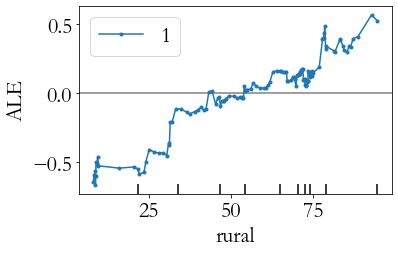

In [20]:
### Get all results for ALE to check function ----
rf_rebel_visi.fit(x_rebel_visi,y_rebel_visi.values.ravel())
proba = rf_rebel_visi.predict_proba
feature_list = list(x_rebel_visi.columns)

ale = ALE(proba, feature_names=feature_list, target_names=[1])
x_s_arr = x_rebel_visi.to_numpy()
exp = ale.explain(x_s_arr)
plot_ale(exp, features=[3])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

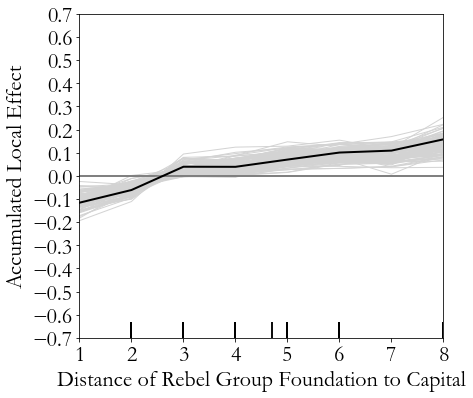

In [21]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility+control, 
        outcome=y, 
        reps=100, 
        feature=0, 
        feat_name_df="foundloc_cat_cat",
        feat_name='Distance of Rebel Group Foundation to Capital', 
        name_out="_foundloc_ale_rebvi", 
        ymin=-0.7,
        ymax=0.7,
        ys=0.1,
        xmin=1, 
        xmax=8,
        xs=1,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

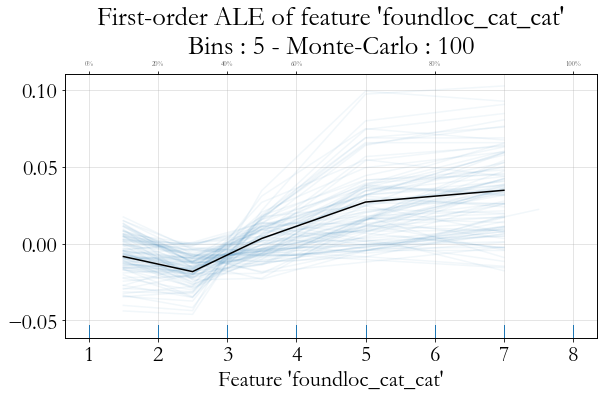

In [22]:
### ALE plot (alternative library) -----
# Source: https://github.com/blent-ai/ALEPython
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_visi,
    x_rebel_visi,
    'foundloc_cat_cat',
    monte_carlo=True,
    monte_carlo_rep=100,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

In [23]:
### Get feature list to double check ---
list_feat

['foundloc_cat_cat',
 'age_formation',
 'forest_cov',
 'rural',
 'terrain',
 'active_year_lag',
 'civil_war_dummy']

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

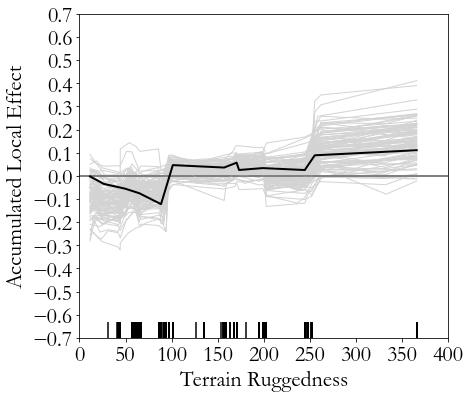

In [24]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility+control, 
        outcome=y, 
        reps=100, 
        feature=4, 
        feat_name_df="terrain",
        feat_name='Terrain Ruggedness', 
        name_out="_terrain_ale_rebvi",
        ymin=-0.7,
        ymax=0.7,
        ys=0.1,
        xmin=0, 
        xmax=400, 
        xs=50,
        bound_upper=96,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

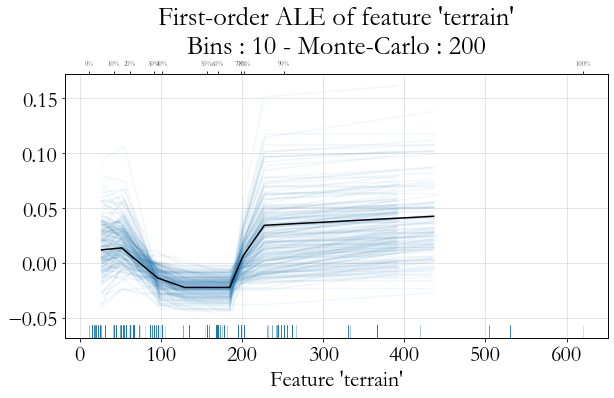

In [25]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_visi,
    x_rebel_visi,
    'terrain',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

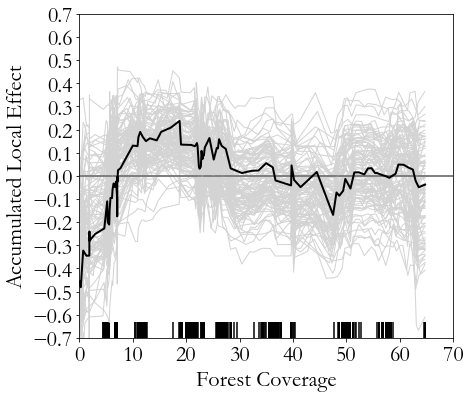

In [26]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility+control, 
        outcome=y, 
        reps=100, 
        feature=2,
        feat_name_df="forest_cov",
        feat_name='Forest Coverage', 
        name_out="_forest_cov_ale_rebvi",
        ymin=-0.7,
        ymax=0.7,
        ys=0.1,
        xmin=0, 
        xmax=70, 
        xs=10,
        bound_upper=97,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

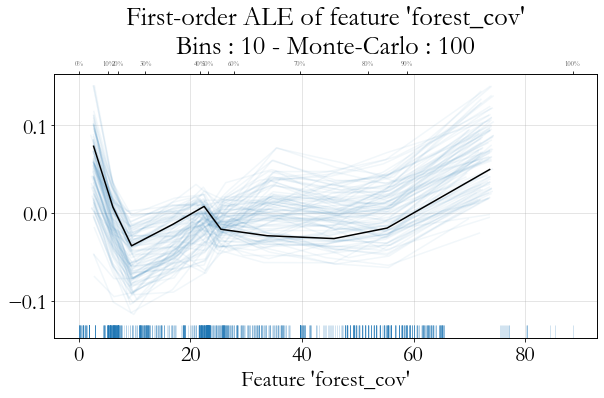

In [27]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_visi,
    x_rebel_visi,
    'forest_cov',
    monte_carlo=True,
    monte_carlo_rep=100,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

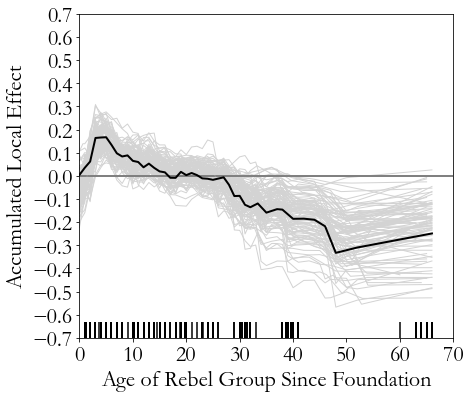

In [28]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility+control, 
        outcome=y, 
        reps=100, 
        feature=1,
        feat_name_df="age_formation",
        feat_name='Age of Rebel Group Since Foundation', 
        name_out="_age_formation_ale_rebvi",
        ymin=-0.7,
        ymax=0.7,
        ys=0.1,
        xmin=0, 
        xmax=70, 
        xs=10,
        bound_upper=100,
        bound_lower=2,
        out=True,
        path=out_paths["plot_ALE"])

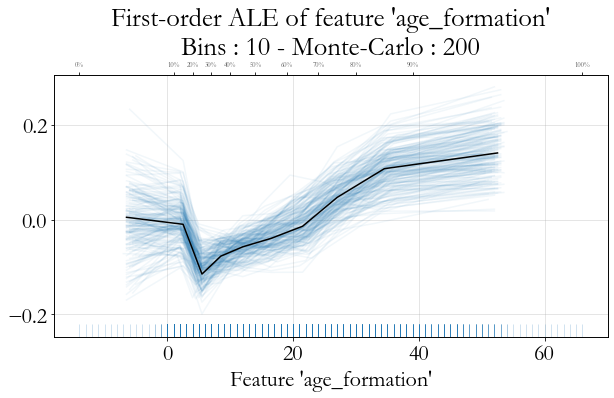

In [29]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_visi,
    x_rebel_visi,
    'age_formation',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
) # this plot looks very different than the one obtained with the other library
# I assume that this is due to how extreme values (percentiles) are dealt with
# Nevertheless, the alibi.explainers.ale library seems more developed which is why I focus on these results

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

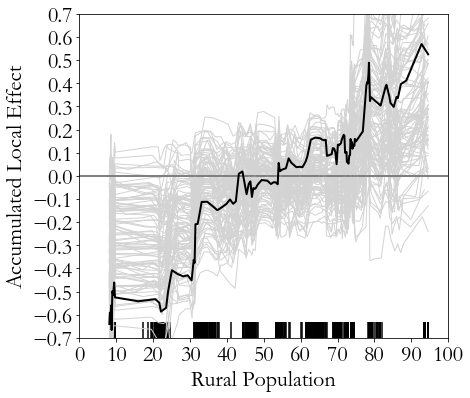

In [30]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility+control, 
        outcome=y, 
        reps=100, 
        feature=3,
        feat_name_df="rural",
        feat_name='Rural Population', 
        name_out="_rural_ale_rebvi", 
        ymin=-0.7,
        ymax=0.7,
        ys=0.1,
        xmin=0, 
        xmax=100, 
        xs=10,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

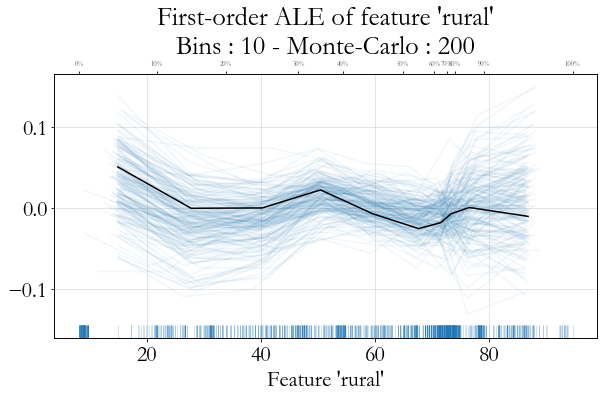

In [31]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_visi,
    x_rebel_visi,
    'rural',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

In [32]:
### Write function to implement k-fold cv -----
# Implemented based on https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/
# and https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

def k_fold_cv(df, model,
             x,
             y,
             suffix,
             n=10
             ):
    
    df[f"predictions_{suffix}"] = np.nan # make empty data column to store predictions
    col_list = []
    
    for i in range(1,n+1): # is repeated n-times
        kf = KFold(n_splits=10, shuffle=True, random_state=i) # define cross validation partitions, 10 splits
        df[f"predictions_{suffix}_cv_{i}"] = cross_val_predict(model, x, y, cv=kf, method='predict_proba')[:, 1] # predict probabilities
        # and extract predictions for y=1
        col_list.append(f"predictions_{suffix}_cv_{i}")
        print(f"Finished cv {i}")
    
    # aggregate to final prediction by taking the mean
    df[f"predictions_{suffix}"] = df[col_list].mean(axis=1)
    
    return 

In [33]:
### Make predictions based on k-fold cv ------
k_fold_cv(df_rebel_visibility, rf_rebel_visi, x_rebel_visi, y_rebel_visi, suffix="rebel_visibility")
df_rebel_visibility.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


foundloc_cat_cat  age_formation  forest_cov  \
ccode_wb dyad_new_id year                                                
IRN      406         1989               2.0           44.0   35.289601   
                     1990               2.0           45.0    5.572374   
                     1991               2.0           46.0    5.587699   

                            rural  terrain  active_year_lag  \
ccode_wb dyad_new_id year                                     
IRN      406         1989  44.206    244.5              0.0   
                     1990  43.670    244.5              0.0   
                     1991  43.135    244.5              1.0   

                           active_year_onset_drop  civil_war_dummy  \
ccode_wb dyad_new_id year                                            
IRN      406         1989                       0                0   
                     1990                       1                0   
                     1991                       0                0   

                           predictions_rebel_visibility  \
ccode_wb dyad_new_id year                                 
IRN      406         1989                      0.292067   
                     1990                      0.230800   
                     1991                      0.070200   

                           predictions_rebel_visibility_cv_1  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.306   
                     1990                              0.206   
                     1991                              0.066   

                           predictions_rebel_visibility_cv_2  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.252   
                     1990                              0.222   
                     1991                              0.074   

                           predictions_rebel_visibility_cv_3  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                           0.309333   
                     1990                           0.236000   
                     1991                           0.094000   

                           predictions_rebel_visibility_cv_4  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.254   
                     1990                              0.206   
                     1991                              0.072   

                           predictions_rebel_visibility_cv_5  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.219   
                     1990                              0.306   
                     1991                              0.022   

                           predictions_rebel_visibility_cv_6  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.358   
                     1990                              0.218   
                     1991                              0.064   

                           predictions_rebel_visibility_cv_7  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.368   
                     1990                              0.250   
                     1991                              0.074   

                           predictions_rebel_visibility_cv_8  \
ccode_wb dyad_new_id year                                      
IRN      406         1989                              0.322   
                     1990                              0.226   
                     1991                              0.100   

                           predictions_rebel_visibility_cv_9  \
ccode_wb dyad_new_id year                                    

In [34]:
### Write function to get evaluations -------
# Implemented based on https://scikit-learn.org/stable/modules/model_evaluation.html

def evaluations(df, 
                predictions, 
                actual, 
                model_name):
    # make empty data frame to store results
    table = pd.DataFrame(columns=['Model', 'Brier', 'AUROC', 'AUPR'])

    # calculate brier
    brier = brier_score_loss(df[f"{actual}"], df[f"{predictions}"])
    print('Brier:', round(np.mean(brier), 4))
    
    # get false_postive, true_positive, precision, recall
    false_positive, true_positive, threshold = metrics.roc_curve(df[f"{actual}"], df[f"{predictions}"])
    precision, recall, threshold = metrics.precision_recall_curve(df[f"{actual}"], df[f"{predictions}"])
    
    # calculate auroc
    auroc = metrics.auc(false_positive, true_positive)
    print('AUROC:', round(np.mean(auroc), 4))
    
    # calculate aupr
    aupr = metrics.auc(recall, precision)
    print('AUPR:', round(np.mean(aupr), 4))
    
    # generate table
    table = table.append({'Model': model_name, 'Brier': brier, 'AUROC': auroc, 'AUPR': aupr}, ignore_index=True)
    
    return false_positive, true_positive, auroc, precision, recall, aupr, table

In [35]:
### Get evaluation scores ---------
fpr_rebel_visi, tpr_rebel_visi, roc_auc_rebel_visi, precision_rebel_visi, recall_rebel_visi, pr_auc_rebel_visi, table_rebel_visi = evaluations(
                                                                                                    df_rebel_visibility, "predictions_rebel_visibility", 
                                                                                                    "active_year_onset_drop", "Rebel Visibility Model")
table_rebel_visi

Brier: 0.1419
AUROC: 0.8284
AUPR: 0.6566


Model     Brier     AUROC     AUPR
0  Rebel Visibility Model  0.141913  0.828386  0.65658

In [36]:
### Write Function to plot ROC PR  ---------
# Implemented on the basis of https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

def roc_pr_plot(false_positive, 
                true_positive, 
                auroc,
                precision, 
                recall, 
                aupr, 
                name, 
                out=True):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # plot roc curve
    axes[0].plot(false_positive, true_positive, 'black', label = 'AUC = %0.2f' % auroc)
    axes[0].title.set_text('Receiver Operating Characteristics Curve')
    axes[0].legend(loc="lower right", prop={'size': 10})
    axes[0].set_ylim([0, 1])
    axes[0].set_xlim([0, 1])
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')

    # plot pr curve
    axes[1].plot(recall, precision, 'black', label = 'AUC = %0.2f' % aupr)
    axes[1].title.set_text('Precision-Recall Curve')
    axes[1].legend(loc="lower left", prop={'size': 10})
    axes[1].set_ylim([0, 1])
    axes[1].set_xlim([0, 1])
    axes[1].set_ylabel('Precision')
    axes[1].set_xlabel('Recall')

    # save figure
    if out == True:
        fig.savefig(os.path.join(out_paths["evaluation"], f"_roc_pr_plot_{name}.png"), dpi=100)
        
    return fig

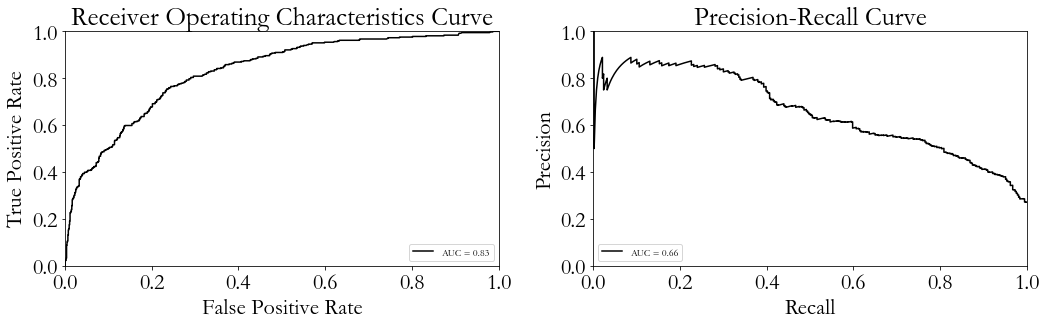

In [37]:
### Plot ROC PR curves ------
roc_pr_plot_rebel_visi = roc_pr_plot(fpr_rebel_visi, tpr_rebel_visi, roc_auc_rebel_visi, \
                                     precision_rebel_visi, recall_rebel_visi, pr_auc_rebel_visi, "rebel_visi")

### Rebel Strength
The following sections implement the rebel strength model which includes the following variables: intensity of goals, intensity of ideology, ethnic identity, whether the rebel group originated from a non-state armed group, from a state group, from a merger or from a civil society organization, oil rents and Internet usage.

In [38]:
### Prepare data --------
df_rebel_strength = df_s[df_s.columns & feat_social_networks + feat_natural_resources + y + control].copy()
df_rebel_strength.head(3)

goal_total  ideo_total  ident_ethnicity  \
ccode_wb dyad_new_id year                                            
IRN      406         1989         1.0         1.0              1.0   
                     1990         1.0         1.0              1.0   
                     1991         1.0         1.0              1.0   

                           parent_splinter_nonstate  parent_splinter_state  \
ccode_wb dyad_new_id year                                                    
IRN      406         1989                       0.0                    0.0   
                     1990                       0.0                    0.0   
                     1991                       0.0                    0.0   

                           parent_civil_society  parent_merger  \
ccode_wb dyad_new_id year                                        
IRN      406         1989                   1.0            0.0   
                     1990                   1.0            0.0   
                     1991                   1.0            0.0   

                           active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989              0.0                       0   
                     1990              0.0                       1   
                     1991              1.0                       0   

                           civil_war_dummy   oil_log  internet_use_log  
ccode_wb dyad_new_id year                                               
IRN      406         1989                0  2.783226          1.660256  
                     1990                0  3.112403          0.000000  
                     1991                0  2.385613          0.000000

In [39]:
### Get data ---------
y_rebel_strength = df_rebel_strength['active_year_onset_drop'].copy()
x_rebel_strength = df_rebel_strength.drop('active_year_onset_drop', axis = 1).copy()

In [40]:
### Check for missing values ---
df_rebel_strength.isnull().any()

goal_total                  False
ideo_total                  False
ident_ethnicity             False
parent_splinter_nonstate    False
parent_splinter_state       False
parent_civil_society        False
parent_merger               False
active_year_lag             False
active_year_onset_drop      False
civil_war_dummy             False
oil_log                     False
internet_use_log            False
dtype: bool

In [41]:
### Estimate random forest -----
rf_rebel_strength = RandomForestClassifier(n_estimators=500, # with 500 trees
                                          random_state=1)
rf_rebel_strength.fit(x_rebel_strength,y_rebel_strength.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=1)

In [42]:
### Get feature importance scores -----
feat_imp(rf_rebel_strength,
         feat_social_networks+feat_natural_resources+control,
         dict_feat_names,
         "rebel_strength")

Feature Name  Importance Score
0                          Transition to Civil War          0.307849
1               Transition to Civil Conflict (lag)          0.297419
2                             Internet Usage (log)          0.073510
3                              Count of Ideologies          0.060099
4                                  Oil Rents (log)          0.057288
5                                   Count of Goals          0.055914
6                            Ethnicity  (Identity)          0.035565
7   Splinter Non-State (Pre-existing Organization)          0.033952
8               Merger (Pre-existing Organization)          0.030817
9        Civil Society (Pre-existing Organization)          0.025578
10      Splinter State (Pre-existing Organization)          0.022010

In [43]:
### Function to get partial dependence plots ---------
# Implemented based on https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
def partial_dependency_plot_dummy(model, 
                            x,
                            df,
                            feature,
                            ymax=1,
                            featurename='--',
                            out=True,
                            path=out_paths["pdplots"],
                            name="test"):
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # plot partial dependence and ICE curves
    fig = plot_partial_dependence(model, x, [feature], ax=ax, 
                              kind="both", random_state=0,
                              line_kw={"color": "lightgray", "linewidth": "0"}, percentiles=(0,1))

    
    # set plot parameters
    plt.ylabel("Predicted Probability y=1", fontsize=18)
    plt.xlabel(f'{featurename}', fontsize=18)
    plt.ylim([0, ymax])
    plt.yticks(np.arange(0, ymax+0.2, 0.2))
    plt.xlim(["No", "Yes"])
    plt.xticks([0, 1])
    black_patch = Line2D([0], [0], color='black', label='Average')
    plt.legend(handles=[black_patch], loc='upper right',fontsize=15)
    fig.lines_[0,0,-1].set_color('black')
    fig.lines_[0,0,-1].set_linewidth('2')

    if out==True:
        plt.savefig(os.path.join(path, f"{name}"), dpi=100)

    return fig

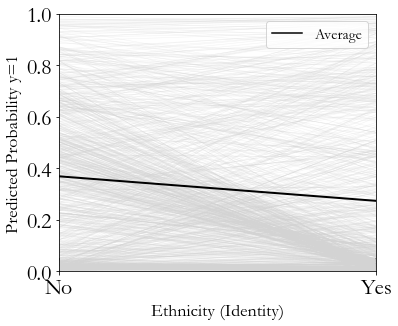

In [44]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_rebel_strength, 
                              x=x_rebel_strength, 
                              df=df_rebel_strength, 
                              feature="ident_ethnicity", 
                              ymax=1, 
                              featurename="Ethnicity (Identity)",
                              out=True,
                              path=out_paths["pdplots"],
                              name="_ident_ethnicity_scikit_reps")

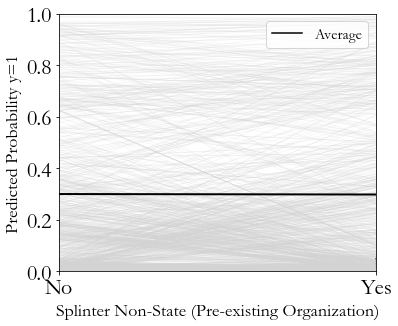

In [45]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_rebel_strength, 
                              x=x_rebel_strength, 
                              df=df_rebel_strength, 
                              feature="parent_splinter_nonstate", 
                              ymax=1, 
                              featurename="Splinter Non-State (Pre-existing Organization)",
                              out=True,
                              path=out_paths["pdplots"],
                              name="_parent_splinter_nonstate_scikit_reps")

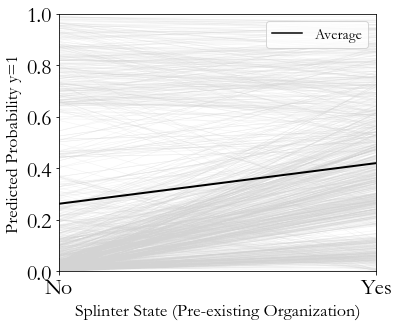

In [46]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_rebel_strength, 
                              x=x_rebel_strength, 
                              df=df_rebel_strength, 
                              feature="parent_splinter_state", 
                              ymax=1, 
                              featurename="Splinter State (Pre-existing Organization)",
                              out=True,
                              path=out_paths["pdplots"],
                              name="_parent_splinter_state_scikit_reps")

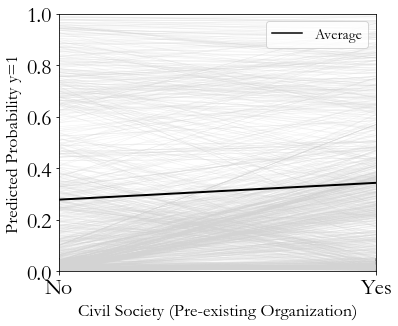

In [47]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_rebel_strength, 
                              x=x_rebel_strength, 
                              df=df_rebel_strength, 
                              feature="parent_civil_society", 
                              ymax=1, 
                              featurename="Civil Society (Pre-existing Organization)",
                              out=True,
                              path=out_paths["pdplots"],
                              name="_parent_civil_society_scikit_reps")

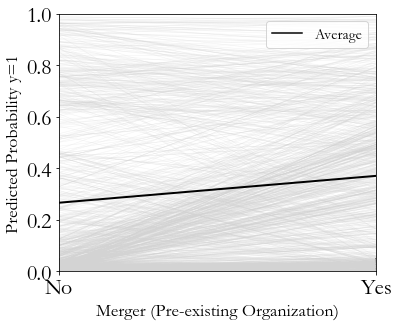

In [48]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_rebel_strength, 
                              x=x_rebel_strength, 
                              df=df_rebel_strength, 
                              feature="parent_merger", 
                              ymax=1, 
                              featurename="Merger (Pre-existing Organization)",
                              out=True,
                              path=out_paths["pdplots"],
                              name="_parent_merger_scikit_reps")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001284F2AB630>]],
      dtype=object)

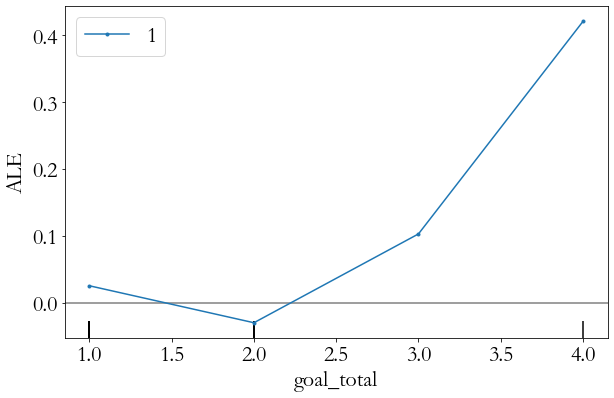

In [49]:
### Get all results for ALE to double check function ----
rf_rebel_strength.fit(x_rebel_strength,y_rebel_strength.values.ravel())
proba = rf_rebel_strength.predict_proba
feature_list = list(x_rebel_strength.columns)

ale = ALE(proba, feature_names=feature_list, target_names=[1])
x_s_arr = x_rebel_strength.to_numpy()
exp = ale.explain(x_s_arr)
plot_ale(exp, features=[0])

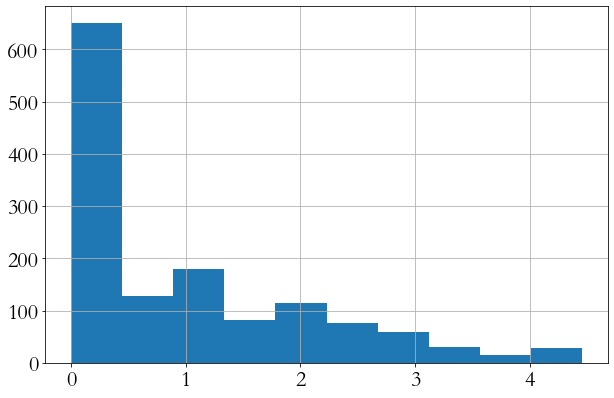

In [50]:
### Check distribution of newly generated variables Internet usage log-transformed ------
df_s["internet_use_log"].hist()

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

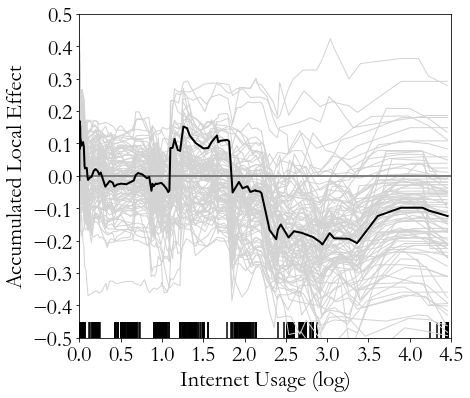

In [51]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_social_networks + feat_natural_resources + control, 
        outcome=y, 
        reps=100, 
        feature=10,
        feat_name_df="internet_use_log",
        feat_name='Internet Usage (log)', 
        name_out="_internet_use_ale_reps", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=0, 
        xmax=4.5, 
        xs=0.5,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

In [52]:
### Get feature list to double check ---
list_feat

['goal_total',
 'ideo_total',
 'ident_ethnicity',
 'parent_splinter_nonstate',
 'parent_splinter_state',
 'parent_civil_society',
 'parent_merger',
 'active_year_lag',
 'civil_war_dummy',
 'oil_log',
 'internet_use_log']

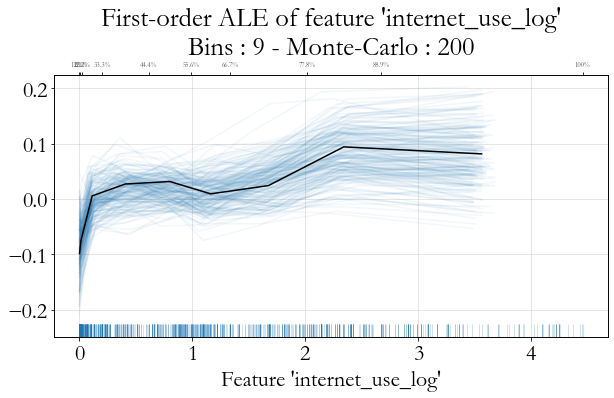

In [53]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_strength,
    x_rebel_strength,
    'internet_use_log',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
) # Again, results from the alterative library look different (see comment above)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

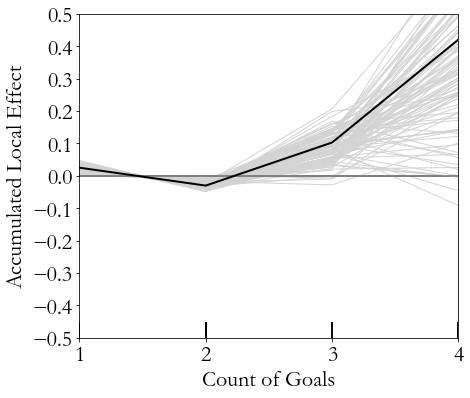

In [54]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_social_networks + feat_natural_resources + control, 
        outcome=y, 
        reps=100, 
        feature=0,
        feat_name_df="goal_total",
        feat_name='Count of Goals', 
        name_out="_goal_total_ale_reps", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=1, 
        xmax=4, 
        xs=1,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

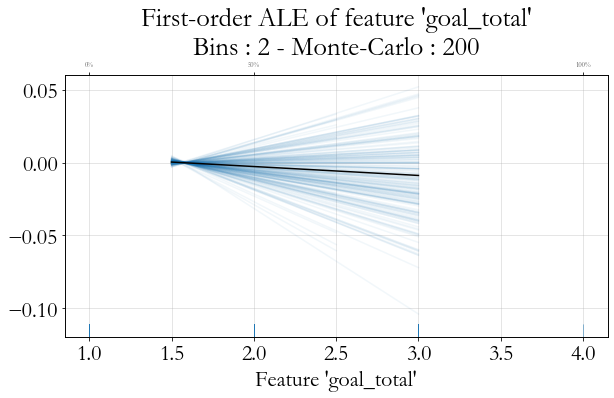

In [55]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_strength,
    x_rebel_strength,
    'goal_total',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

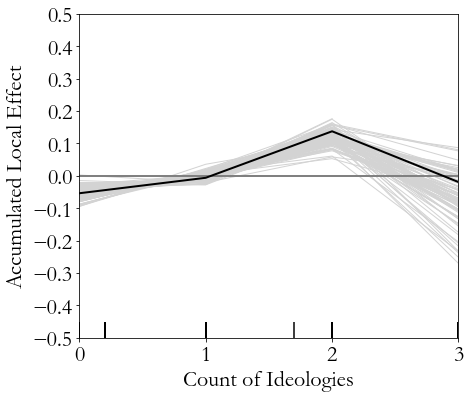

In [56]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_social_networks + feat_natural_resources + control, 
        outcome=y, 
        reps=100, 
        feature=1, 
        feat_name_df="ideo_total",
        feat_name='Count of Ideologies', 
        name_out="_ideo_total_ale_reps", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=0, 
        xmax=3, 
        xs=1,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

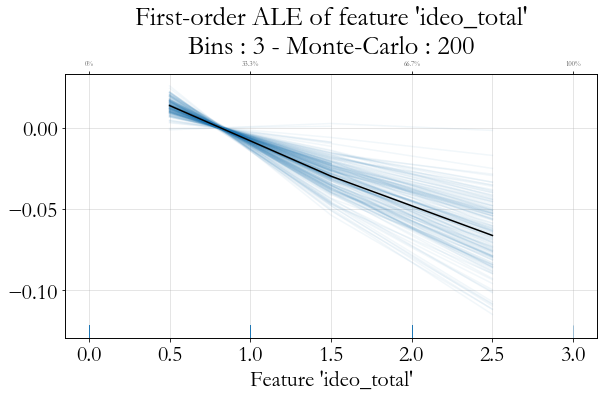

In [57]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_strength,
    x_rebel_strength,
    'ideo_total',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

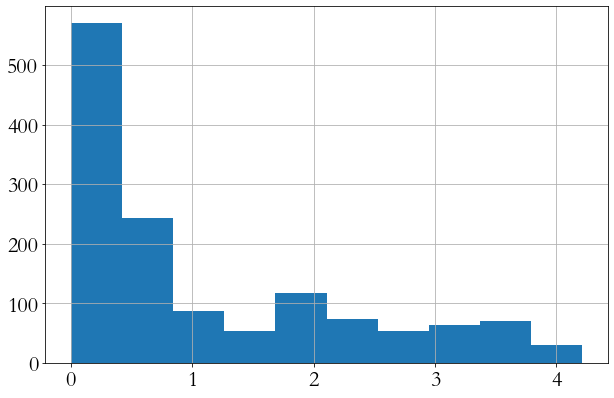

In [58]:
### Check distribution of newly generated variables oil rents log-transformed ------
df_s["oil_log"].hist()

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

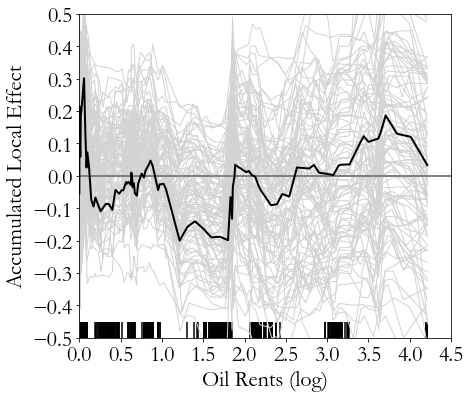

In [59]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_social_networks + feat_natural_resources + control, 
        outcome=y, 
        reps=100, 
        feature=9, 
        feat_name_df="oil_log",
        feat_name='Oil Rents (log)', 
        name_out="_oil_ale_reps", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=0, 
        xmax=4.5, 
        xs=0.5,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

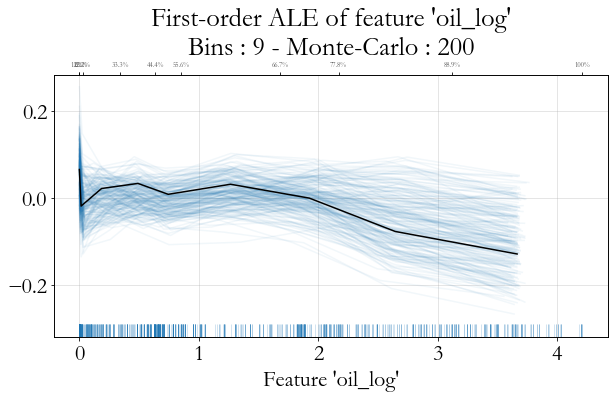

In [60]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_rebel_strength,
    x_rebel_strength,
    'oil_log',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

In [61]:
### Make predictions based on k-fold cv ------
k_fold_cv(df_rebel_strength, rf_rebel_strength, x_rebel_strength, y_rebel_strength, suffix="rebel_strength")
df_rebel_strength.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


goal_total  ideo_total  ident_ethnicity  \
ccode_wb dyad_new_id year                                            
IRN      406         1989         1.0         1.0              1.0   
                     1990         1.0         1.0              1.0   
                     1991         1.0         1.0              1.0   

                           parent_splinter_nonstate  parent_splinter_state  \
ccode_wb dyad_new_id year                                                    
IRN      406         1989                       0.0                    0.0   
                     1990                       0.0                    0.0   
                     1991                       0.0                    0.0   

                           parent_civil_society  parent_merger  \
ccode_wb dyad_new_id year                                        
IRN      406         1989                   1.0            0.0   
                     1990                   1.0            0.0   
                     1991                   1.0            0.0   

                           active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989              0.0                       0   
                     1990              0.0                       1   
                     1991              1.0                       0   

                           civil_war_dummy  ...  \
ccode_wb dyad_new_id year                   ...   
IRN      406         1989                0  ...   
                     1990                0  ...   
                     1991                0  ...   

                           predictions_rebel_strength_cv_1  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                            0.076   
                     1990                            0.663   
                     1991                            0.022   

                           predictions_rebel_strength_cv_2  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                            0.072   
                     1990                            0.668   
                     1991                            0.028   

                           predictions_rebel_strength_cv_3  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                            0.092   
                     1990                            0.664   
                     1991                            0.018   

                           predictions_rebel_strength_cv_4  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                            0.060   
                     1990                            0.358   
                     1991                            0.012   

                           predictions_rebel_strength_cv_5  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.049333   
                     1990                         0.653333   
                     1991                         0.018000   

                           predictions_rebel_strength_cv_6  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                            0.062   
                     1990                            0.654   
                     1991                            0.024   

                           predictions_rebel_strength_cv_7  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                            0.074   
                     1990                            0.610   
                     1991                            0.024   

                           predictions_rebel_strength_cv_8  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                     

In [62]:
### Get evaluation scores ---------
fpr_rebel_strength, tpr_rebel_strength, roc_auc_rebel_strength, precision_rebel_strength, \
     recall_rebel_strength, pr_auc_rebel_strength, table_rebel_strength = evaluations(df_rebel_strength, "predictions_rebel_strength", 
                                                                                                    "active_year_onset_drop", "Rebel Strength Model")
table_rebel_strength

Brier: 0.1557
AUROC: 0.7926
AUPR: 0.586


Model     Brier     AUROC      AUPR
0  Rebel Strength Model  0.155662  0.792562  0.586042

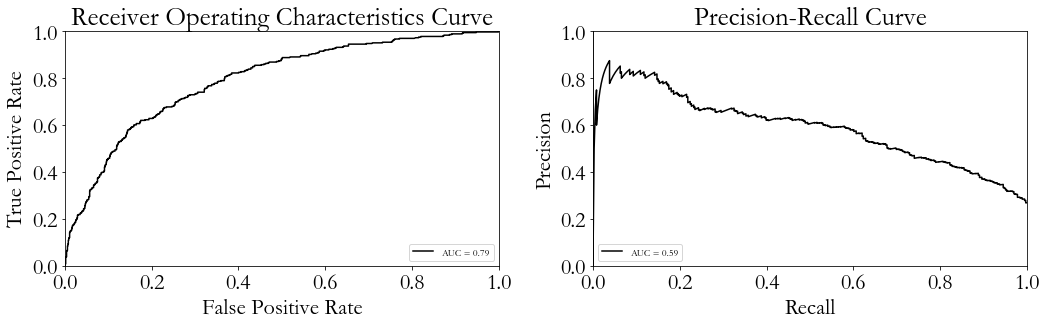

In [63]:
### Plot ROC PR curves ------
roc_pr_plot_rebel_strength = roc_pr_plot(fpr_rebel_strength, tpr_rebel_strength, roc_auc_rebel_strength, \
                                     precision_rebel_strength, recall_rebel_strength, pr_auc_rebel_strength, "rebel_strength")

### State Capacity Model
This section implements the state capacity model which includes the following variables: quality of government, military expenditure index, military personnel index and the combined polity score.

In [64]:
### Prepare data -----
df_state_capacity = df_s[df_s.columns & feat_state_capacity + y + control].copy()
df_state_capacity.head(3)

gov_qual  milexp_in  milper_in  polity2  \
ccode_wb dyad_new_id year                                            
IRN      406         1989  0.305556   1.813994   1.207825     -6.0   
                     1990  0.305556   1.840000   0.520000     -6.0   
                     1991  0.370370   1.520000   0.520000     -6.0   

                           active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989              0.0                       0   
                     1990              0.0                       1   
                     1991              1.0                       0   

                           civil_war_dummy  
ccode_wb dyad_new_id year                   
IRN      406         1989                0  
                     1990                0  
                     1991                0

In [65]:
### Get data  -------
y_state_capacity = df_state_capacity['active_year_onset_drop'].copy()
x_state_capacity = df_state_capacity.drop('active_year_onset_drop', axis = 1).copy()

In [66]:
### Check for missing values ---
df_state_capacity.isnull().any()

gov_qual                  False
milexp_in                 False
milper_in                 False
polity2                   False
active_year_lag           False
active_year_onset_drop    False
civil_war_dummy           False
dtype: bool

In [67]:
### Estimate random forest -----
rf_state_capacity = RandomForestClassifier(n_estimators=500, # with 500 trees
                                           random_state=1)

rf_state_capacity.fit(x_state_capacity,y_state_capacity.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=1)

In [68]:
### Get feature importance scores -----
feat_imp(rf_state_capacity,
         feat_state_capacity + control,
         dict_feat_names,
         "state_capacity")

Feature Name  Importance Score
0          Military Expenditure Index          0.246696
1               Quality of Government          0.235248
2            Military Personnel Index          0.233337
3               Combined Polity Score          0.135830
4             Transition to Civil War          0.082244
5  Transition to Civil Conflict (lag)          0.066644

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001285268EE10>]],
      dtype=object)

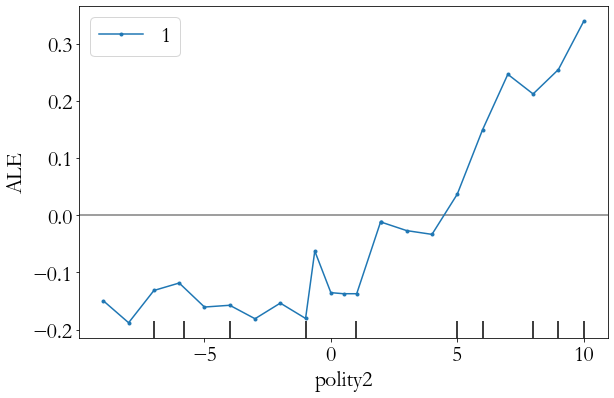

In [69]:
### Get all results for ALE to double check function ----
rf_state_capacity.fit(x_state_capacity,y_state_capacity.values.ravel())
proba = rf_state_capacity.predict_proba
feature_list = list(x_state_capacity.columns)

ale = ALE(proba, feature_names=feature_list, target_names=[1])
x_s_arr = x_state_capacity.to_numpy()
exp = ale.explain(x_s_arr)
plot_ale(exp, features=[3])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

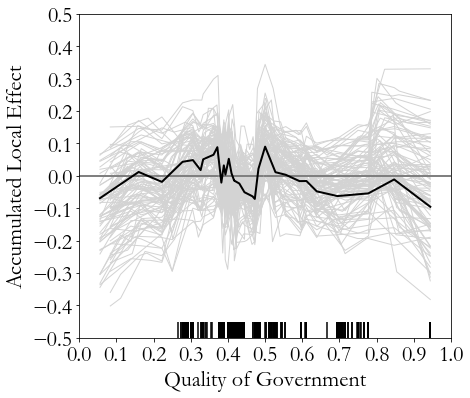

In [70]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_state_capacity + control, 
        outcome=y, 
        reps=100, 
        feature=0, 
        feat_name_df="gov_qual",
        feat_name='Quality of Government', 
        name_out="_gov_qual_ale_state", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=0, 
        xmax=1, 
        xs=0.1,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

In [71]:
### Get feature list to double check ---
list_feat

['gov_qual',
 'milexp_in',
 'milper_in',
 'polity2',
 'active_year_lag',
 'civil_war_dummy']

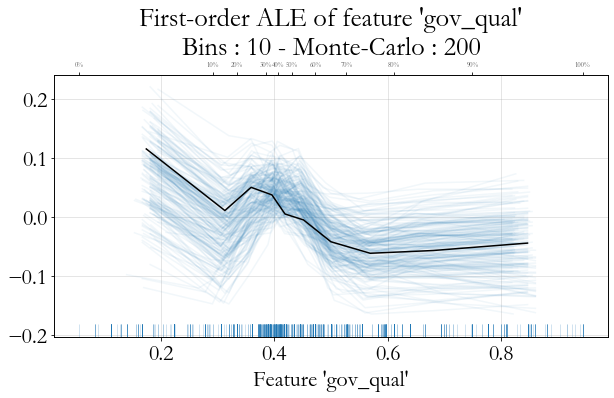

In [72]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_state_capacity,
    x_state_capacity,
    'gov_qual',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

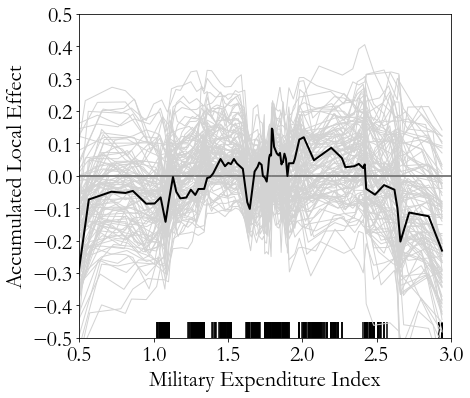

In [73]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_state_capacity + control, 
        outcome=y, 
        reps=100, 
        feature=1, 
        feat_name_df="milexp_in",
        feat_name='Military Expenditure Index', 
        name_out="_milexp_in_ale_state", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=0.5, 
        xmax=3, 
        xs=0.5,
        bound_upper=95,
        bound_lower=1,
        out=True,
        path=out_paths["plot_ALE"])

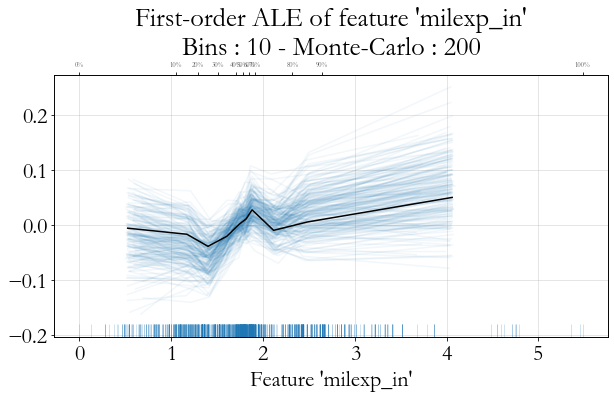

In [74]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_state_capacity,
    x_state_capacity,
    'milexp_in',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

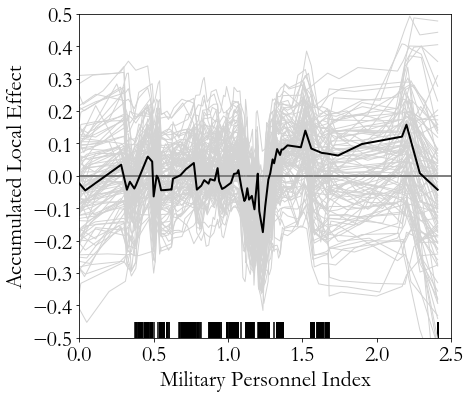

In [75]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_state_capacity + control, 
        outcome=y, 
        reps=100, 
        feature=2, 
        feat_name_df="milper_in",
        feat_name='Military Personnel Index', 
        name_out="_milper_in_ale_state", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=0, 
        xmax=2.5, 
        xs=0.5,
        bound_upper=95,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

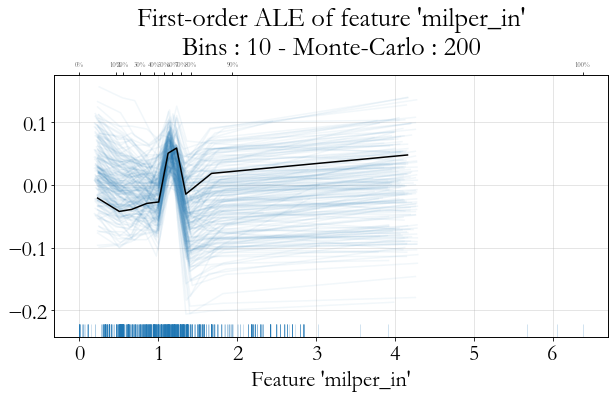

In [76]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_state_capacity,
    x_state_capacity,
    'milper_in',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10
Done with repetition 11
Done with repetition 12
Done with repetition 13
Done with repetition 14
Done with repetition 15
Done with repetition 16
Done with repetition 17
Done with repetition 18
Done with repetition 19
Done with repetition 20
Done with repetition 21
Done with repetition 22
Done with repetition 23
Done with repetition 24
Done with repetition 25
Done with repetition 26
Done with repetition 27
Done with repetition 28
Done with repetition 29
Done with repetition 30
Done with repetition 31
Done with repetition 32
Done with repetition 33
Done with repetition 34
Done with repetition 35
Done with repetition 36
Done with repetition 37
Done with repetition 38
Done with repetition 39
Done with repetition 40
Done with repetition 41
Done with repetition 42
D

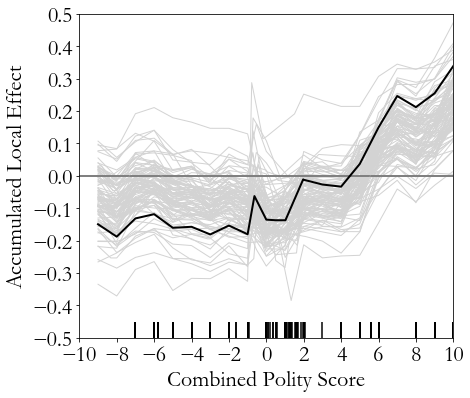

In [77]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_state_capacity + control, 
        outcome=y, 
        reps=100, 
        feature=3, 
        feat_name_df="polity2",
        feat_name='Combined Polity Score', 
        name_out="_polity2_ale_state", 
        ymin=-0.5,
        ymax=0.5,
        ys=0.1,
        xmin=-10, 
        xmax=10, 
        xs=2,
        bound_upper=100,
        bound_lower=0,
        out=True,
        path=out_paths["plot_ALE"])

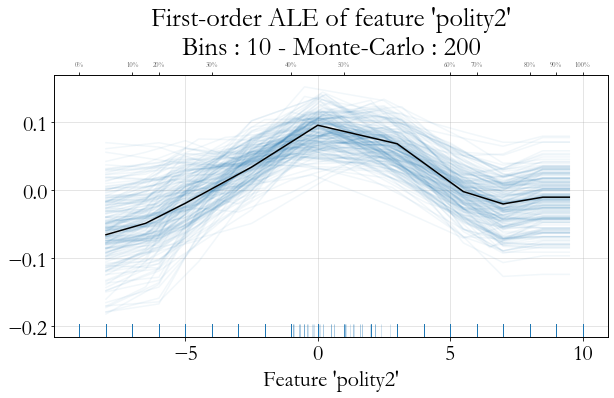

In [78]:
### ALE plot (alternative library) -----
plt.rc("figure", figsize=(9, 6))
ale_plot(
    rf_state_capacity,
    x_state_capacity,
    'polity2',
    monte_carlo=True,
    monte_carlo_rep=200,
    monte_carlo_ratio=0.8,
    rugplot_lim = None
)

In [79]:
### Make predictions based on k-fold cv ------
k_fold_cv(df_state_capacity, rf_state_capacity, x_state_capacity, y_state_capacity, suffix="state_capacity")
df_state_capacity.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


gov_qual  milexp_in  milper_in  polity2  \
ccode_wb dyad_new_id year                                            
IRN      406         1989  0.305556   1.813994   1.207825     -6.0   
                     1990  0.305556   1.840000   0.520000     -6.0   
                     1991  0.370370   1.520000   0.520000     -6.0   

                           active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989              0.0                       0   
                     1990              0.0                       1   
                     1991              1.0                       0   

                           civil_war_dummy  predictions_state_capacity  \
ccode_wb dyad_new_id year                                                
IRN      406         1989                0                    0.513653   
                     1990                0                    0.171631   
                     1991                0                    0.039750   

                           predictions_state_capacity_cv_1  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.662290   
                     1990                         0.177267   
                     1991                         0.026500   

                           predictions_state_capacity_cv_2  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.730357   
                     1990                         0.189487   
                     1991                         0.057000   

                           predictions_state_capacity_cv_3  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.285425   
                     1990                         0.168067   
                     1991                         0.046000   

                           predictions_state_capacity_cv_4  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.626576   
                     1990                         0.170000   
                     1991                         0.046000   

                           predictions_state_capacity_cv_5  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.259927   
                     1990                         0.170273   
                     1991                         0.024000   

                           predictions_state_capacity_cv_6  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                          0.55498   
                     1990                          0.19900   
                     1991                          0.04400   

                           predictions_state_capacity_cv_7  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.612210   
                     1990                         0.168033   
                     1991                         0.034000   

                           predictions_state_capacity_cv_8  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.313813   
                     1990                         0.132617   
                     1991                         0.040000   

                           predictions_state_capacity_cv_9  \
ccode_wb dyad_new_id year                                    
IRN      406         1989                         0.575798   
                     1990                         0.166686   
                     1991                         0.044000   

                           predictions_state_capacity_cv_10  
ccode_wb dyad_new_id year                                    
IRN      406         1989      

In [80]:
### Get evaluation scores ---------
fpr_state_capacity, tpr_state_capacity, roc_auc_state_capacity, precision_state_capacity, \
     recall_state_capacity, pr_auc_state_capacity, table_state_capacity = evaluations(df_state_capacity, "predictions_state_capacity", 
                                                                                                    "active_year_onset_drop", "State Capacity Model")
table_state_capacity

Brier: 0.1693
AUROC: 0.7521
AUPR: 0.5805


Model     Brier     AUROC     AUPR
0  State Capacity Model  0.169252  0.752118  0.58047

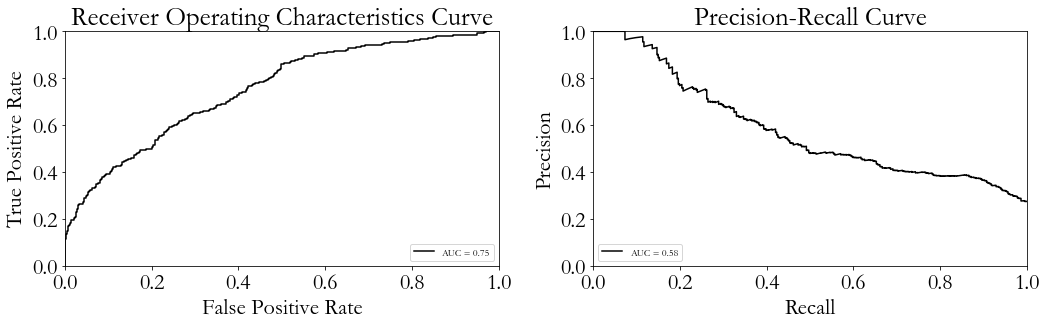

In [81]:
### Plot ROC PR curves ------
roc_pr_plot_state_capacity = roc_pr_plot(fpr_state_capacity, tpr_state_capacity, roc_auc_state_capacity, \
                                     precision_state_capacity, recall_state_capacity, pr_auc_state_capacity, "state_capacity")

### Baseline Model
This section implements the baseline mode. The baseline model includes the following variables a lagged dependent variable and the civil war dummy variable. 

In [82]:
### Prepare data -----
df_control = df_s[df_s.columns & y + control].copy()
df_control.head(3)

active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989              0.0                       0   
                     1990              0.0                       1   
                     1991              1.0                       0   

                           civil_war_dummy  
ccode_wb dyad_new_id year                   
IRN      406         1989                0  
                     1990                0  
                     1991                0

In [83]:
### Get data -------
y_control = df_control['active_year_onset_drop'].copy()
x_control = df_control.drop('active_year_onset_drop', axis = 1).copy()

In [84]:
### Check for missing values ---
df_control.isnull().any()

active_year_lag           False
active_year_onset_drop    False
civil_war_dummy           False
dtype: bool

In [85]:
### Estimate random forest -----
rf_control = RandomForestClassifier(n_estimators=500, # with 500 trees
                                    random_state=1)
rf_control.fit(x_control,y_control.values.ravel())

RandomForestClassifier(n_estimators=500, random_state=1)

In [86]:
### Get feature importance scores -----
feat_imp(rf_control,
         control,
         dict_feat_names,
         "control")

Feature Name  Importance Score
0  Transition to Civil Conflict (lag)          0.515314
1             Transition to Civil War          0.484686

In [87]:
### Make predictions based on k-fold cv ------
k_fold_cv(df_control, rf_control, x_control, y_control, suffix="control")
df_control.head(3)

Finished cv 1
Finished cv 2
Finished cv 3
Finished cv 4
Finished cv 5
Finished cv 6
Finished cv 7
Finished cv 8
Finished cv 9
Finished cv 10


active_year_lag  active_year_onset_drop  \
ccode_wb dyad_new_id year                                            
IRN      406         1989              0.0                       0   
                     1990              0.0                       1   
                     1991              1.0                       0   

                           civil_war_dummy  predictions_control  \
ccode_wb dyad_new_id year                                         
IRN      406         1989                0             0.298758   
                     1990                0             0.298879   
                     1991                0             0.000000   

                           predictions_control_cv_1  predictions_control_cv_2  \
ccode_wb dyad_new_id year                                                       
IRN      406         1989                   0.29977                  0.297814   
                     1990                   0.29977                  0.297488   
                     1991                   0.00000                  0.000000   

                           predictions_control_cv_3  predictions_control_cv_4  \
ccode_wb dyad_new_id year                                                       
IRN      406         1989                  0.298428                  0.296810   
                     1990                  0.293999                  0.306475   
                     1991                  0.000000                  0.000000   

                           predictions_control_cv_5  predictions_control_cv_6  \
ccode_wb dyad_new_id year                                                       
IRN      406         1989                  0.296109                  0.301311   
                     1990                  0.302616                  0.295383   
                     1991                  0.000000                  0.000000   

                           predictions_control_cv_7  predictions_control_cv_8  \
ccode_wb dyad_new_id year                                                       
IRN      406         1989                  0.297189                  0.301591   
                     1990                  0.294549                  0.303427   
                     1991                  0.000000                  0.000000   

                           predictions_control_cv_9  predictions_control_cv_10  
ccode_wb dyad_new_id year                                                       
IRN      406         1989                   0.30016                   0.298401  
                     1990                   0.30016                   0.294924  
                     1991                   0.00000                   0.000000

In [88]:
### Get evaluation scores ---------
fpr_control, tpr_control, roc_auc_control, precision_control, \
     recall_control, pr_auc_control, table_control = evaluations(df_control, "predictions_control", 
                                                    "active_year_onset_drop", "Baseline Model")
table_control

Brier: 0.1717
AUROC: 0.5316
AUPR: 0.3506


Model     Brier     AUROC      AUPR
0  Baseline Model  0.171737  0.531613  0.350573

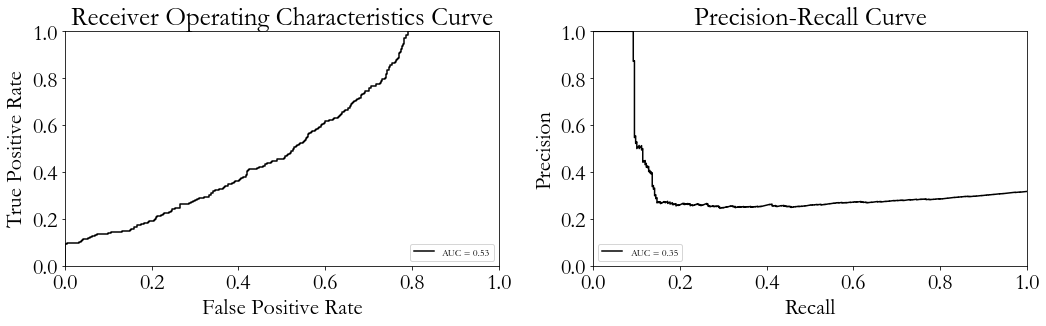

In [89]:
### Plot ROC PR curves ------
roc_pr_plot_control = roc_pr_plot(fpr_control, tpr_control, roc_auc_control, \
                                     precision_control, recall_control, pr_auc_control, "_control")

### Model Comparison 
The last section of the notebook provides plots and tables to compare prediction accuracy between the models. 

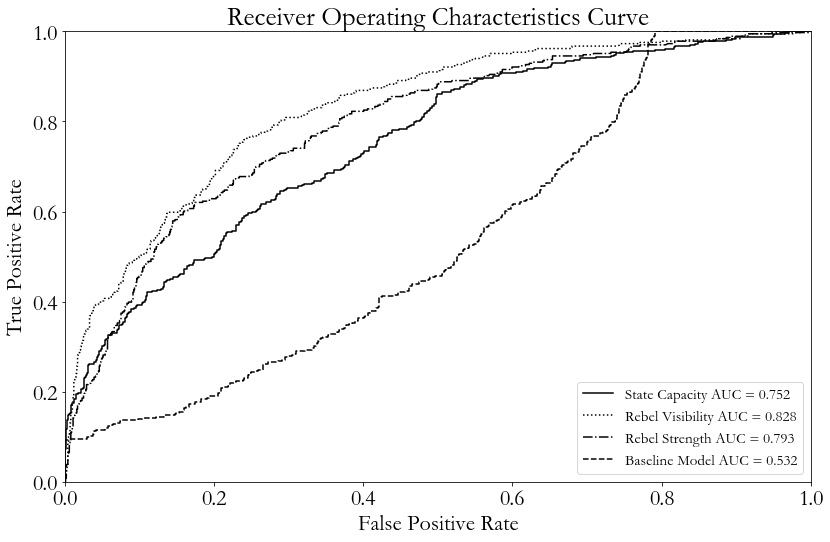

In [90]:
### ROC curves for all models ---------
fig, axes = plt.subplots(figsize=(12, 8))
axes.plot(fpr_state_capacity, tpr_state_capacity, 'black', linestyle='solid', label = 'State Capacity AUC = %0.3f' % roc_auc_state_capacity)
axes.plot(fpr_rebel_visi, tpr_rebel_visi, 'black', linestyle='dotted', label = 'Rebel Visibility AUC = %0.3f' % roc_auc_rebel_visi)
axes.plot(fpr_rebel_strength, tpr_rebel_strength, 'black', linestyle='dashdot', label = 'Rebel Strength AUC = %0.3f' % roc_auc_rebel_strength)
axes.plot(fpr_control, tpr_control, 'black',  linestyle='dashed', label = 'Baseline Model AUC = %0.3f' % roc_auc_control)
axes.title.set_text('Receiver Operating Characteristics Curve')
axes.legend(loc = 'lower right', prop={'size': 15})
axes.set_ylim([0, 1])
axes.set_xlim([0, 1])
axes.set_ylabel('True Positive Rate')
axes.set_xlabel('False Positive Rate')
fig.savefig(os.path.join(out_paths["evaluation"], f"_roc_plot_all.png"), dpi=100)

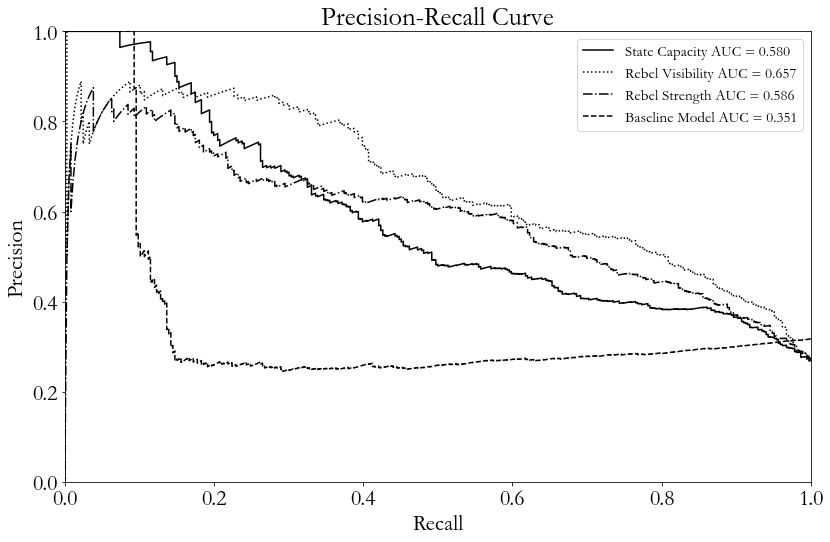

In [91]:
### PR curves for all models ---------
fig, axes = plt.subplots(figsize=(12, 8))
axes.plot(recall_state_capacity, precision_state_capacity, 'black', linestyle='solid', label = 'State Capacity AUC = %0.3f' % pr_auc_state_capacity)
axes.plot(recall_rebel_visi, precision_rebel_visi, 'black', linestyle='dotted', label = 'Rebel Visibility AUC = %0.3f' % pr_auc_rebel_visi)
axes.plot(recall_rebel_strength, precision_rebel_strength, 'black', linestyle='dashdot', label = 'Rebel Strength AUC = %0.3f' % pr_auc_rebel_strength)
axes.plot(recall_control, precision_control, 'black', linestyle='dashed', label = 'Baseline Model AUC = %0.3f' % pr_auc_control)
axes.title.set_text('Precision-Recall Curve')
axes.legend(loc = 'upper right', prop={'size': 15})
axes.set_ylim([0, 1])
axes.set_xlim([0, 1])
axes.set_ylabel('Precision')
axes.set_xlabel('Recall')
fig.savefig(os.path.join(out_paths["evaluation"], f"_pr_plot_all.png"), dpi=100)

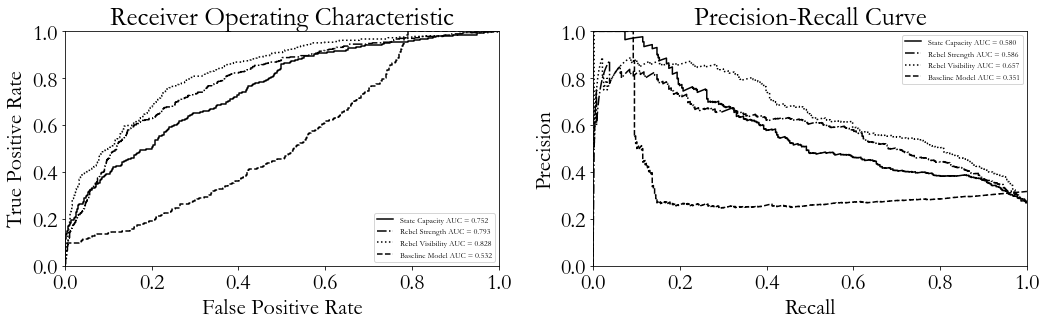

In [92]:
### Combine ROC and PR curves fit for all models ---------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(fpr_state_capacity, tpr_state_capacity, 'black', linestyle='solid', label = 'State Capacity AUC = %0.3f' % roc_auc_state_capacity)
axes[0].plot(fpr_rebel_strength, tpr_rebel_strength, 'black', linestyle='dashdot', label = 'Rebel Strength AUC = %0.3f' % roc_auc_rebel_strength)
axes[0].plot(fpr_rebel_visi, tpr_rebel_visi, 'black', linestyle='dotted', label = 'Rebel Visibility AUC = %0.3f' % roc_auc_rebel_visi)
axes[0].plot(fpr_control, tpr_control, 'black',  linestyle='dashed', label = 'Baseline Model AUC = %0.3f' % roc_auc_control)
axes[0].title.set_text('Receiver Operating Characteristic')
axes[0].legend(loc = 'lower right', prop={'size': 8})
axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, 1])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')

axes[1].plot(recall_state_capacity, precision_state_capacity, 'black', linestyle='solid', label = 'State Capacity AUC = %0.3f' % pr_auc_state_capacity)
axes[1].plot(recall_rebel_strength, precision_rebel_strength, 'black', linestyle='dashdot', label = 'Rebel Strength AUC = %0.3f' % pr_auc_rebel_strength)
axes[1].plot(recall_rebel_visi, precision_rebel_visi, 'black', linestyle='dotted', label = 'Rebel Visibility AUC = %0.3f' % pr_auc_rebel_visi)
axes[1].plot(recall_control, precision_control, 'black', linestyle='dashed', label = 'Baseline Model AUC = %0.3f' % pr_auc_control)
axes[1].title.set_text('Precision-Recall Curve')
axes[1].legend(loc = 'upper right', prop={'size': 8})
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')
fig.savefig(os.path.join(out_paths["evaluation"], f"_roc_pr_plot_all.png"), dpi=100)

In [93]:
### Table showing evaluation scores for all models  ------
pd.options.display.float_format = '{:.5f}'.format
tab_eval_complete = pd.concat([table_state_capacity, table_rebel_visi]) # merge separate models
tab_eval_complete = pd.concat([tab_eval_complete, table_rebel_strength])
tab_eval_complete = pd.concat([tab_eval_complete, table_control])
tab_eval_complete = tab_eval_complete.round(decimals=5)

# Save table
tab_eval_complete.to_latex(os.path.join(out_paths["evaluation"], f"_eval_table_all.tex"), index=False)
tab_eval_complete

Model   Brier   AUROC    AUPR
0    State Capacity Model 0.16925 0.75212 0.58047
0  Rebel Visibility Model 0.14191 0.82839 0.65658
0    Rebel Strength Model 0.15566 0.79256 0.58604
0          Baseline Model 0.17174 0.53161 0.35057

### Explore Potential Interactions
The following section combines some of the thematic models to investigate potential interactions between variables. This is rather experimental and I suspect that the dataset does not show enough variation to properly plot two-dimensional effects.   

In [94]:
### Prepare data ------
df_all = df_s[df_s.columns & feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + y + control]
df_all.head(3)

# Get data 
y_all = df_all['active_year_onset_drop']
x_all = df_all.drop('active_year_onset_drop', axis = 1)

In [95]:
### Check for missing values ---
df_all.isnull().any()

goal_total                  False
ideo_total                  False
foundloc_cat_cat            False
age_formation               False
ident_ethnicity             False
parent_splinter_nonstate    False
parent_splinter_state       False
parent_civil_society        False
parent_merger               False
forest_cov                  False
rural                       False
terrain                     False
gov_qual                    False
milexp_in                   False
milper_in                   False
polity2                     False
active_year_lag             False
active_year_onset_drop      False
civil_war_dummy             False
oil_log                     False
internet_use_log            False
dtype: bool

In [96]:
### Estimate random forest -----
rf_all = RandomForestClassifier(n_estimators=500, 
                                random_state=1)
rf_all.fit(x_all,y_all)

RandomForestClassifier(n_estimators=500, random_state=1)

In [97]:
### Get feature importance scores -----
feat_imp(rf_all,
         feat_rebel_visibility + feat_social_networks  + feat_natural_resources + 
         feat_state_capacity +
         control,
         dict_feat_names,
         "all")

Feature Name  Importance Score
0                               Terrain Ruggedness           0.17820
1        Civil Society (Pre-existing Organization)           0.08290
2       Splinter State (Pre-existing Organization)           0.07759
3                             Internet Usage (log)           0.07527
4                          Transition to Civil War           0.07075
5                                  Oil Rents (log)           0.07029
6                            Quality of Government           0.06801
7               Transition to Civil Conflict (lag)           0.06223
8                         Military Personnel Index           0.06066
9                       Military Expenditure Index           0.04273
10              Merger (Pre-existing Organization)           0.03725
11                           Combined Polity Score           0.03675
12                               Rural Population            0.03214
13                                Forest Coverage            0.02216
14   Location of Rebel Group Foundation to Capital           0.01967
15             Age of Rebel Group Since Foundation           0.01664
16                                  Count of Goals           0.01478
17  Splinter Non-State (Pre-existing Organization)           0.01235
18                           Ethnicity  (Identity)           0.01192
19                             Count of Ideologies           0.00773

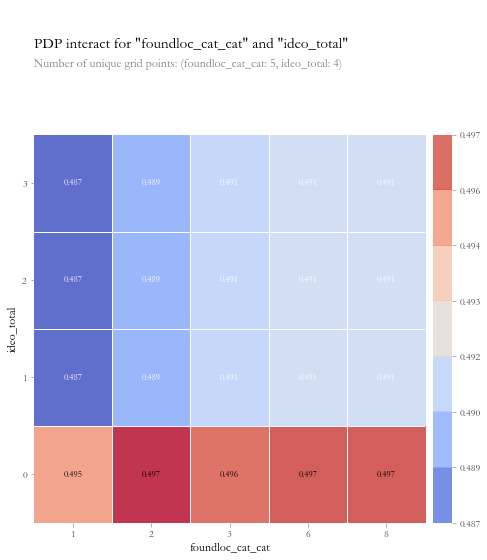

In [98]:
### Plot (two dimensions) ------
params = {
    'contour_color': 'white', 
    'font_family': 'Garamond',
    'cmap': 'coolwarm',} # define plot parameters

# initiate plot
pdp_inter = pdp.pdp_interact(model=rf_all,
             dataset=df_s,
             model_features=feat_rebel_visibility + feat_social_networks + 
                             feat_state_capacity + 
                             feat_natural_resources + control,
             features=['foundloc_cat_cat', 'ideo_total'])

# generate plot 
pdp.pdp_interact_plot(pdp_inter, ['foundloc_cat_cat', 'ideo_total'], plot_type='grid', plot_params=params)
plt.show()

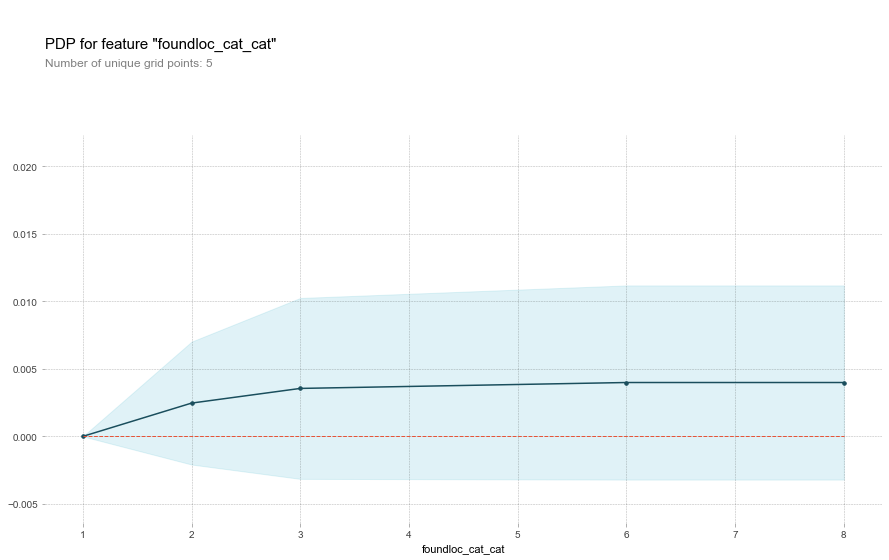

In [99]:
### Plot (one dimension) -----
# initiate plot
pdp_one = pdp.pdp_isolate(model=rf_all,
             dataset=df_s,
             model_features=feat_rebel_visibility + feat_social_networks + 
                          feat_state_capacity + 
                          feat_natural_resources + control,
             feature='foundloc_cat_cat')

# generate plot 
pdp.pdp_plot(pdp_one, 'foundloc_cat_cat')
plt.show()

### Models with all Features
The effect plots are re-estimated by combining all features in one model. The effects do not really change in sign but in size. Some effect plots also change substantially which makes sense since all features are included and there might be associations between variables belonging to different thematic models. 

In [100]:
### Prepare data ------
df_all = df_s[df_s.columns & feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + y + control]
df_all.head(3)

# Get data 
y_all = df_all['active_year_onset_drop']
x_all = df_all.drop('active_year_onset_drop', axis = 1)

In [101]:
### Check for missing values ---
df_all.isnull().any()

goal_total                  False
ideo_total                  False
foundloc_cat_cat            False
age_formation               False
ident_ethnicity             False
parent_splinter_nonstate    False
parent_splinter_state       False
parent_civil_society        False
parent_merger               False
forest_cov                  False
rural                       False
terrain                     False
gov_qual                    False
milexp_in                   False
milper_in                   False
polity2                     False
active_year_lag             False
active_year_onset_drop      False
civil_war_dummy             False
oil_log                     False
internet_use_log            False
dtype: bool

In [102]:
### Estimate random forest -----
rf_all = RandomForestClassifier(n_estimators=500, 
                                random_state=1)
rf_all.fit(x_all,y_all)

RandomForestClassifier(n_estimators=500, random_state=1)

In [103]:
### Get feature importance scores -----
feat_imp(rf_all,
         feat_rebel_visibility + feat_social_networks  + feat_natural_resources + 
         feat_state_capacity +
         control,
         dict_feat_names,
         "all")

Feature Name  Importance Score
0                               Terrain Ruggedness           0.17820
1        Civil Society (Pre-existing Organization)           0.08290
2       Splinter State (Pre-existing Organization)           0.07759
3                             Internet Usage (log)           0.07527
4                          Transition to Civil War           0.07075
5                                  Oil Rents (log)           0.07029
6                            Quality of Government           0.06801
7               Transition to Civil Conflict (lag)           0.06223
8                         Military Personnel Index           0.06066
9                       Military Expenditure Index           0.04273
10              Merger (Pre-existing Organization)           0.03725
11                           Combined Polity Score           0.03675
12                               Rural Population            0.03214
13                                Forest Coverage            0.02216
14   Location of Rebel Group Foundation to Capital           0.01967
15             Age of Rebel Group Since Foundation           0.01664
16                                  Count of Goals           0.01478
17  Splinter Non-State (Pre-existing Organization)           0.01235
18                           Ethnicity  (Identity)           0.01192
19                             Count of Ideologies           0.00773

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012856D16A20>]],
      dtype=object)

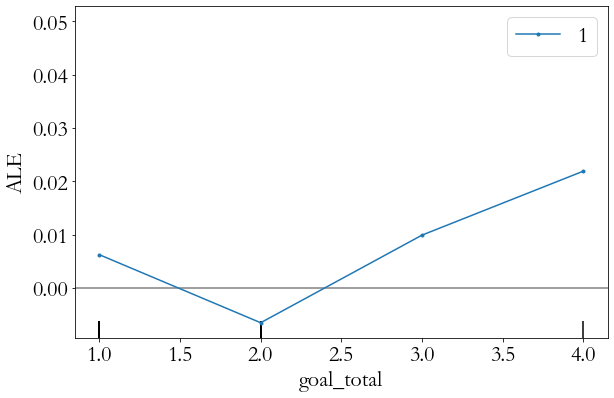

In [104]:
### Get all results for ALE to double check function ----
rf_all.fit(x_all,y_all.values.ravel())
proba = rf_all.predict_proba
feature_list = list(x_all.columns)

ale = ALE(proba, feature_names=feature_list, target_names=[1])
x_s_arr = x_all.to_numpy()
exp = ale.explain(x_s_arr)
plot_ale(exp, features=[0])

In [105]:
### Get feature list ----
feature_list

['goal_total',
 'ideo_total',
 'foundloc_cat_cat',
 'age_formation',
 'ident_ethnicity',
 'parent_splinter_nonstate',
 'parent_splinter_state',
 'parent_civil_society',
 'parent_merger',
 'forest_cov',
 'rural',
 'terrain',
 'gov_qual',
 'milexp_in',
 'milper_in',
 'polity2',
 'active_year_lag',
 'civil_war_dummy',
 'oil_log',
 'internet_use_log']

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


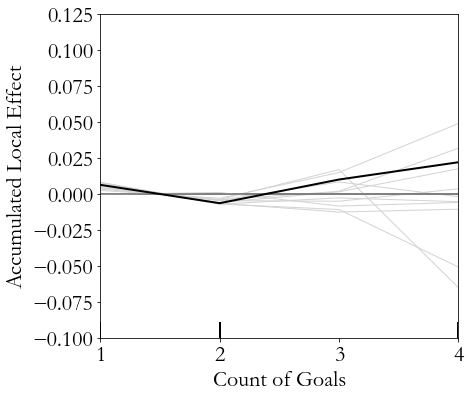

In [106]:
### ALE plot -----
# Set repetitions to a lower number so reduce computational complexity --> set to 10
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=0,
        feat_name_df="goal_total",
        feat_name='Count of Goals', 
        name_out="_goal_total_ale_all", 
        ymin=-0.1,
        ymax=0.05,
        ys=0.025,
        xmin=1, 
        xmax=4, 
        xs=1,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


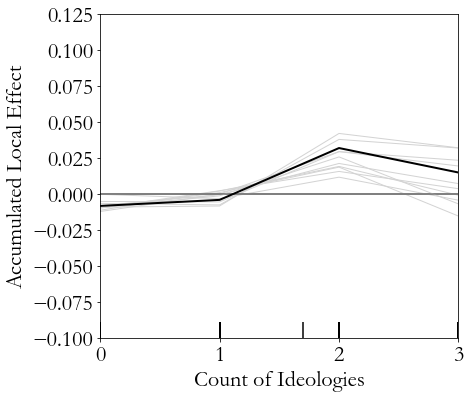

In [107]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=1, 
        feat_name_df="ideo_total",
        feat_name='Count of Ideologies', 
        name_out="_ideo_total_ale_all", 
        ymin=-0.1,
        ymax=0.05,
        ys=0.025,
        xmin=0, 
        xmax=3, 
        xs=1,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


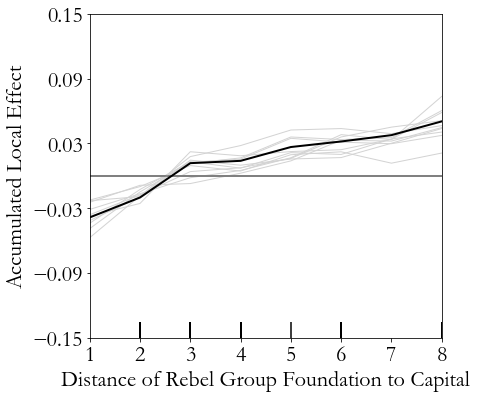

In [108]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=2, 
        feat_name_df="foundloc_cat_cat",
        feat_name='Distance of Rebel Group Foundation to Capital', 
        name_out="_foundloc_ale_all", 
        ymin=-0.15,
        ymax=0.1,
        ys=0.06,
        xmin=1, 
        xmax=8,
        xs=1,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


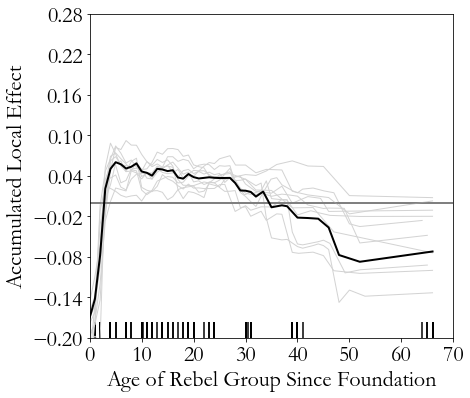

In [109]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control,  
        outcome=y, 
        reps=10, 
        feature=3,
        feat_name_df="age_formation",
        feat_name='Age of Rebel Group Since Foundation', 
        name_out="_age_formation_ale_all",
        ymin=-0.2,
        ymax=0.2,
        ys=0.06,
        xmin=0, 
        xmax=70, 
        xs=10,
        bound_upper=100,
        bound_lower=2,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


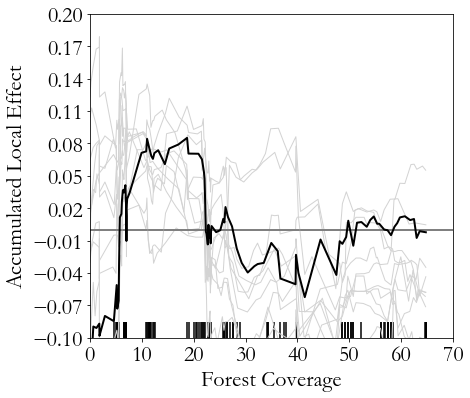

In [110]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=9,
        feat_name_df="forest_cov",
        feat_name='Forest Coverage', 
        name_out="_forest_cov_ale_all",
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=0, 
        xmax=70, 
        xs=10,
        bound_upper=97,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


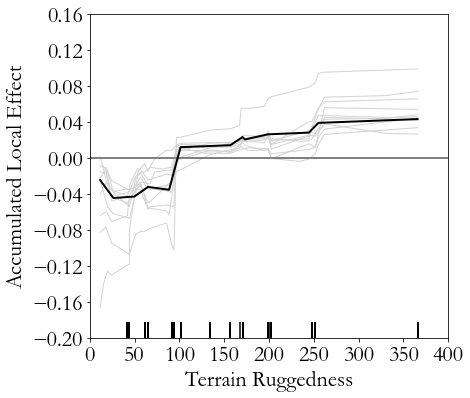

In [111]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control,
        outcome=y, 
        reps=10, 
        feature=11, 
        feat_name_df="terrain",
        feat_name='Terrain Ruggedness', 
        name_out="_terrain_ale_all",
        ymin=-0.2,
        ymax=0.1,
        ys=0.04,
        xmin=0, 
        xmax=400, 
        xs=50,
        bound_upper=96,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


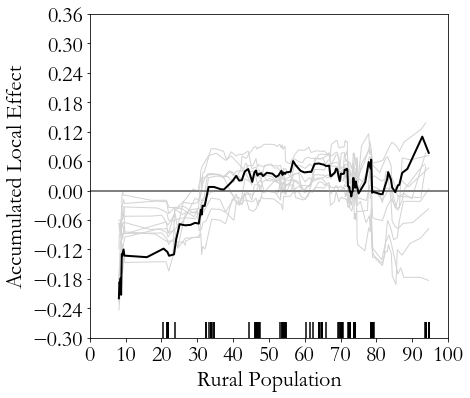

In [112]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=10,
        feat_name_df="rural",
        feat_name='Rural Population', 
        name_out="_rural_ale_all", 
        ymin=-0.3,
        ymax=0.3,
        ys=0.06,
        xmin=0, 
        xmax=100, 
        xs=10,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


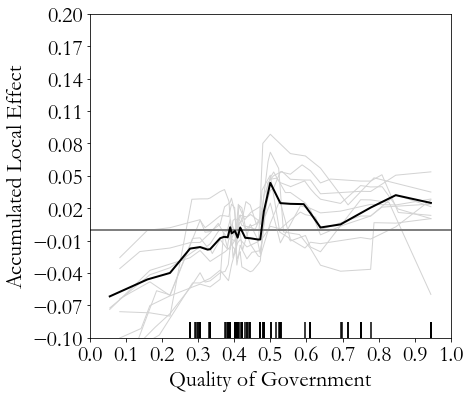

In [113]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=12, 
        feat_name_df="gov_qual",
        feat_name='Quality of Government', 
        name_out="_gov_qual_ale_all", 
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=0, 
        xmax=1, 
        xs=0.1,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"]) 

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


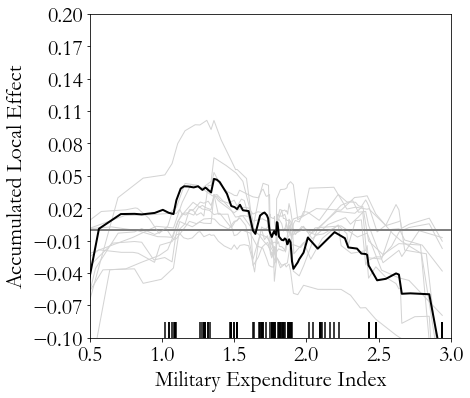

In [114]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=13, 
        feat_name_df="milexp_in",
        feat_name='Military Expenditure Index', 
        name_out="_milexp_in_ale_all", 
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=0.5, 
        xmax=3, 
        xs=0.5,
        bound_upper=95,
        bound_lower=1,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


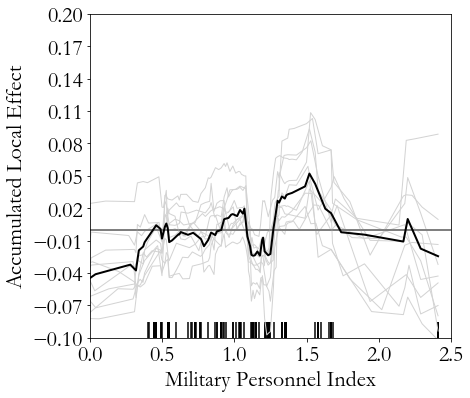

In [115]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control,
        outcome=y, 
        reps=10, 
        feature=14, 
        feat_name_df="milper_in",
        feat_name='Military Personnel Index', 
        name_out="_milper_in_ale_all", 
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=0, 
        xmax=2.5, 
        xs=0.5,
        bound_upper=95,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"]) 

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


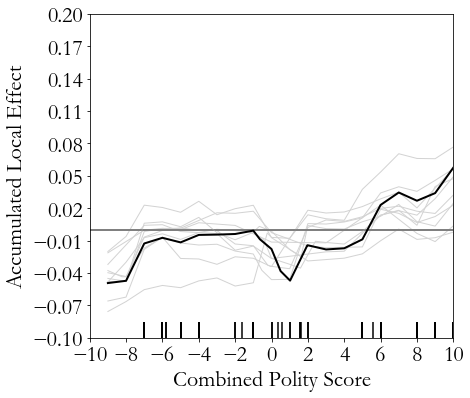

In [116]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=15, 
        feat_name_df="polity2",
        feat_name='Combined Polity Score', 
        name_out="_polity2_ale_all", 
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=-10, 
        xmax=10, 
        xs=2,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


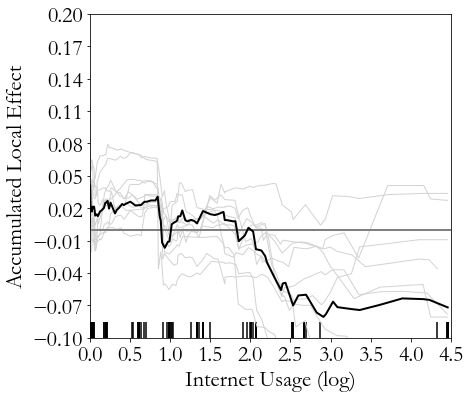

In [117]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control, 
        outcome=y, 
        reps=10, 
        feature=19,
        feat_name_df="internet_use_log",
        feat_name='Internet Usage (log)', 
        name_out="_internet_use_ale_all", 
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=0, 
        xmax=4.5, 
        xs=0.5,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

Done with repetition 1
Done with repetition 2
Done with repetition 3
Done with repetition 4
Done with repetition 5
Done with repetition 6
Done with repetition 7
Done with repetition 8
Done with repetition 9
Done with repetition 10


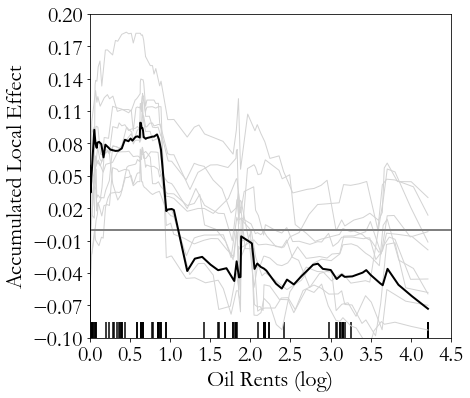

In [118]:
### ALE plot -----
list_feat = _plot_ale_(df=df_s, 
        featlist=feat_rebel_visibility + feat_social_networks + feat_state_capacity + feat_natural_resources + control,  
        outcome=y, 
        reps=10, 
        feature=18, 
        feat_name_df="oil_log",
        feat_name='Oil Rents (log)', 
        name_out="_oil_ale_all", 
        ymin=-0.1,
        ymax=0.1,
        ys=0.03,
        xmin=0, 
        xmax=4.5, 
        xs=0.5,
        bound_upper=100,
        bound_lower=0,
        out=False,
        path=out_paths["plot_ALE"])

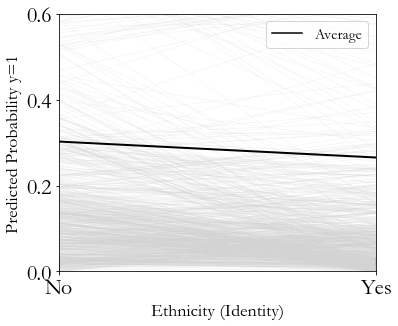

In [119]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_all, 
                              x=x_all, 
                              df=df_all, 
                              feature="ident_ethnicity", 
                              ymax=0.5, 
                              featurename="Ethnicity (Identity)",
                              out=False,
                              path=out_paths["pdplots"],
                              name="_ident_ethnicity_scikit_all")

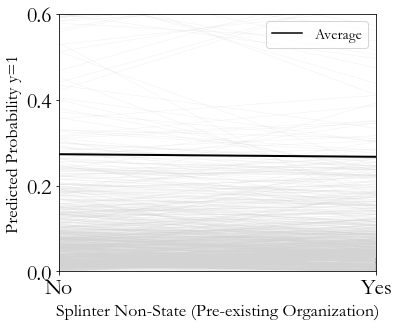

In [120]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_all, 
                              x=x_all, 
                              df=df_all, 
                              feature="parent_splinter_nonstate", 
                              ymax=0.5, 
                              featurename="Splinter Non-State (Pre-existing Organization)",
                              out=False,
                              path=out_paths["pdplots"],
                              name="_parent_splinter_nonstate_scikit_all")

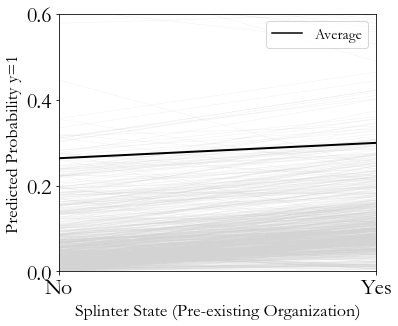

In [121]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_all, 
                              x=x_all, 
                              df=df_all, 
                              feature="parent_splinter_state", 
                              ymax=0.5, 
                              featurename="Splinter State (Pre-existing Organization)",
                              out=False,
                              path=out_paths["pdplots"],
                              name="_parent_splinter_state_scikit_all")

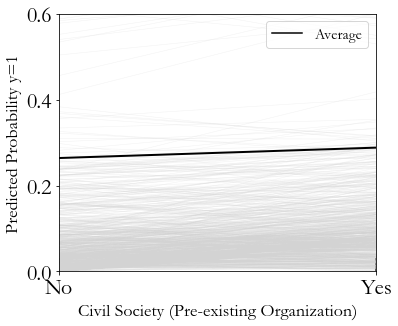

In [122]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_all, 
                              x=x_all, 
                              df=df_all, 
                              feature="parent_civil_society", 
                              ymax=0.5, 
                              featurename="Civil Society (Pre-existing Organization)",
                              out=False,
                              path=out_paths["pdplots"],
                              name="_parent_civil_society_scikit_all")

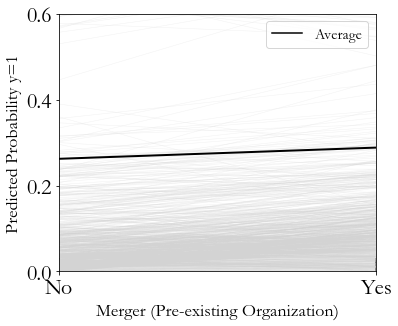

In [123]:
### Make partial dependency plots ----
partial_dependency_plot_dummy(model=rf_all, 
                              x=x_all, 
                              df=df_all, 
                              feature="parent_merger", 
                              ymax=0.5, 
                              featurename="Merger (Pre-existing Organization)",
                              out=False,
                              path=out_paths["pdplots"],
                              name="_parent_merger_scikit_all")